In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip ml-20m.zip


--2025-12-03 12:29:23--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  71.6MB/s    in 2.6s    

2025-12-03 12:29:26 (71.6 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings_path = "ml-20m/ratings.csv"
movies_path  = "ml-20m/movies.csv"

ratings = pd.read_csv(ratings_path)
movies  = pd.read_csv(movies_path)

ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
n_users   = ratings['userId'].nunique()
n_items   = ratings['movieId'].nunique()
n_ratings = len(ratings)

print("Users:", n_users)
print("Items:", n_items)
print("Ratings:", n_ratings)

Users: 138493
Items: 26744
Ratings: 20000263


In [ ]:
ratings['rating_1_5'] = (
    ratings['rating']
    .round()
    .clip(1, 5)
    .astype(int)
)
ratings[['rating', 'rating_1_5']].head()

,rating,rating_1_5
0,3.5,4
1,3.5,4
2,3.5,4
3,3.5,4
4,3.5,4


In [ ]:
user_stats = (
    ratings
        .groupby('userId')['rating_1_5']
        .agg(['size', 'mean'])            # old-style aggregation
        .rename(columns={'size': 'n_u', 'mean': 'r_u_bar'})
)

user_stats.head()

,n_u,r_u_bar
userId,,
1,175,3.942857
2,61,4.000000
3,187,4.122995
4,28,3.571429
5,66,4.272727


In [ ]:
user_stats.to_csv("user_stats.csv")

In [ ]:
item_stats = (
    ratings
        .groupby('movieId')['rating_1_5']
        .agg(['size', 'mean'])
        .rename(columns={'size': 'n_i', 'mean': 'r_i_bar'})
)

item_stats.head()

,n_i,r_i_bar
movieId,,
1,49695,3.918161
2,22243,3.232702
3,12735,3.162623
4,2756,2.868287
5,12161,3.076721


In [ ]:
item_stats.to_csv("item_stats.csv", index=True)

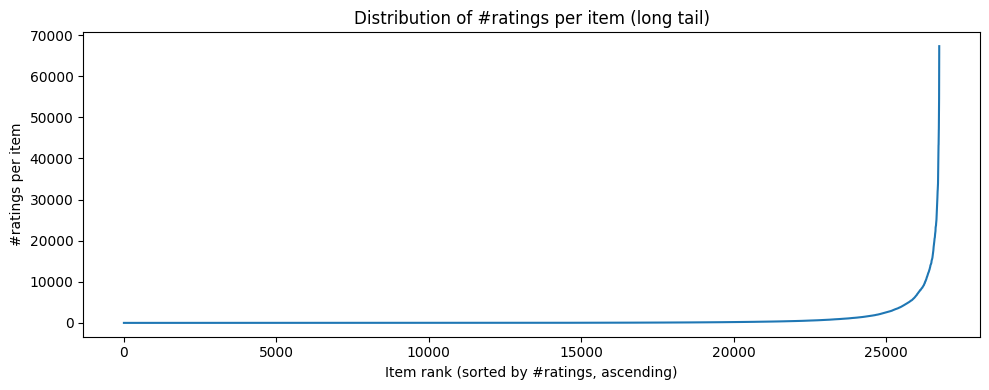

In [ ]:
item_stats_sorted_by_pop = item_stats.sort_values('n_i')

plt.figure(figsize=(10,4))
plt.plot(range(len(item_stats_sorted_by_pop)), item_stats_sorted_by_pop['n_i'].values)
plt.xlabel("Item rank (sorted by #ratings, ascending)")
plt.ylabel("#ratings per item")
plt.title("Distribution of #ratings per item (long tail)")
plt.tight_layout()
plt.show()

In [ ]:
item_stats['avg_pct'] = item_stats['r_i_bar'] / 5.0 * 100

In [ ]:
bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 100]
labels = ['G1','G2','G3','G4','G5','G6','G7','G8','G9','G10']

item_stats['group'] = pd.cut(
    item_stats['avg_pct'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

group_item_counts = item_stats['group'].value_counts().sort_index()
print(group_item_counts)

group
G1        0
G2        0
G3        0
G4      390
G5      157
G6     1887
G7     1975
G8     5831
G9     7444
G10    9060
Name: count, dtype: int64


In [ ]:
ratings_with_group = ratings.merge(
    item_stats[['group']],
    left_on='movieId',
    right_index=True,
    how='left'
)

group_rating_counts = (
    ratings_with_group
    .groupby('group')
    .size()
    .reindex(labels)  # keep G1..G10 order
)

print(group_rating_counts)

group
G1            0
G2            0
G3            0
G4          450
G5         3723
G6        83512
G7       471316
G8      2095168
G9      5350217
G10    11995877
dtype: int64


/tmp/ipython-input-2916814011.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('group')


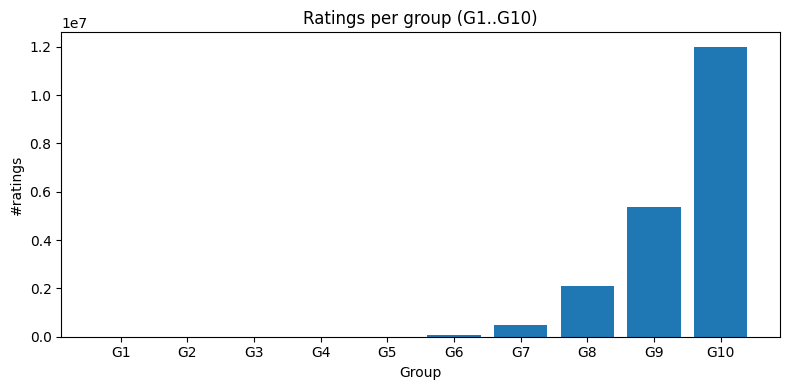

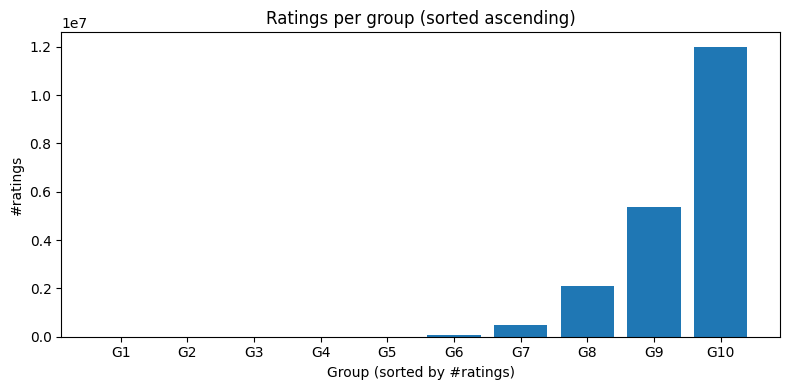

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(group_rating_counts.index.astype(str), group_rating_counts.values)
plt.xlabel("Group")
plt.ylabel("#ratings")
plt.title("Ratings per group (G1..G10)")
plt.tight_layout()
plt.show()

# After ordering by #ratings
group_rating_counts_sorted = group_rating_counts.sort_values()

plt.figure(figsize=(8,4))
plt.bar(group_rating_counts_sorted.index.astype(str), group_rating_counts_sorted.values)
plt.xlabel("Group (sorted by #ratings)")
plt.ylabel("#ratings")
plt.title("Ratings per group (sorted ascending)")
plt.tight_layout()
plt.show()

In [ ]:
total_items = n_items

user_stats['coverage_pct'] = user_stats['n_u'] / total_items * 100

def pick_user(cond, seed=42):
    return user_stats[cond].sample(1, random_state=seed).index[0]

U1 = pick_user(user_stats['coverage_pct'] <= 2, seed=1)
U2 = pick_user((user_stats['coverage_pct'] > 2) & (user_stats['coverage_pct'] <= 5), seed=2)
U3 = pick_user((user_stats['coverage_pct'] > 5) & (user_stats['coverage_pct'] <= 10), seed=3)

target_users = [U1, U2, U3]
print("Target users:", target_users)
print(user_stats.loc[target_users, ['n_u', 'coverage_pct']])

Target users: [np.int64(60419), np.int64(98464), np.int64(96370)]
         n_u  coverage_pct
userId                    
60419    104      0.388872
98464    978      3.656895
96370   2108      7.882142


In [ ]:
candidate_items = item_stats[item_stats['n_i'] >= 50]

lowest_rated = candidate_items.sort_values('r_i_bar')
I1, I2 = lowest_rated.index[:2].tolist()

target_items = [I1, I2]
print("Target items:", target_items)
print(item_stats.loc[target_items])

Target items: [8859, 6483]
         n_i   r_i_bar    avg_pct group
movieId                                
8859     209  1.220096  24.401914    G5
6483     426  1.309859  26.197183    G5


In [ ]:
No_common_users = {}

for u in target_users:
    items_u = set(ratings[ratings['userId'] == u]['movieId'])

    co = ratings[(ratings['movieId'].isin(items_u)) & (ratings['userId'] != u)]
    n_co_users = co['userId'].nunique()
    No_common_users[u] = n_co_users

No_common_users

{60419: 132262, 98464: 138467, 96370: 138485}

In [ ]:
No_coRated_items = {}

for i in target_items:
    users_i = set(ratings[ratings['movieId'] == i]['userId'])
    co = ratings[(ratings['userId'].isin(users_i)) & (ratings['movieId'] != i)]
    n_co_items = co['movieId'].nunique()
    No_coRated_items[i] = n_co_items

No_coRated_items

{8859: 13303, 6483: 14587}

In [ ]:
beta_per_user = {}

for u in target_users:
    items_u = set(ratings[ratings['userId'] == u]['movieId'])
    n_items_u = len(items_u)

    others = ratings[ratings['userId'] != u].groupby('userId')['movieId']

    count_similar = 0
    for v, items_v_series in others:
        items_v = set(items_v_series.values)
        n_common = len(items_u & items_v)
        if n_common >= 0.3 * n_items_u:
            count_similar += 1

    beta_per_user[u] = count_similar
    print(f"User {u}: #users with >=30% co-rated items = {count_similar}")

beta = max(beta_per_user.values())
print("β (max over target users) =", beta)

User 60419: #users with >=30% co-rated items = 8601
User 98464: #users with >=30% co-rated items = 3572
User 96370: #users with >=30% co-rated items = 909
β (max over target users) = 8601


In [ ]:
user_stats.to_csv("user_stats.csv")
item_stats.to_csv("item_stats.csv")
group_item_counts.to_csv("group_item_counts.csv")
group_rating_counts.to_csv("group_rating_counts.csv")

pd.Series(No_common_users, name="No_common_users").to_csv("No_common_users.csv")
pd.Series(No_coRated_items, name="No_coRated_items").to_csv("No_coRated_items.csv")
pd.Series(beta_per_user, name="beta_per_user").to_csv("beta_per_user.csv")

In [ ]:
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pickle
import os


RATINGS_CSV = "ml-20m/ratings.csv"
BETA = 0.30
TOP_PERCENT = 0.20
USE_MEAN_CENTERED = False
SEED = 10

# ---- Load data ----
print("Loading ratings...")
df = pd.read_csv(RATINGS_CSV)
df = df[['userId','movieId','rating']]
df['userId'] = df['userId'].astype(int)
df['movieId'] = df['movieId'].astype(int)


user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()
user_map = {u:i for i,u in enumerate(np.sort(user_ids))}
movie_map = {m:i for i,m in enumerate(np.sort(movie_ids))}
inv_user_map = {v:k for k,v in user_map.items()}
inv_movie_map = {v:k for k,v in movie_map.items()}

df['uidx'] = df['userId'].map(user_map)
df['midx'] = df['movieId'].map(movie_map)

n_users = df['uidx'].nunique()
n_items = df['midx'].nunique()
print(f"Users: {n_users}, Items: {n_items}, Ratings: {len(df)}")

rows = df['uidx'].values
cols = df['midx'].values
vals = df['rating'].values.astype(np.float32)
R = csr_matrix((vals, (rows, cols)), shape=(n_users, n_items))


user_counts = np.diff(R.indptr)
user_means = np.zeros(n_users, dtype=np.float32)
for u in range(n_users):
    start, end = R.indptr[u], R.indptr[u+1]
    if end > start:
        user_means[u] = R.data[start:end].mean()
    else:
        user_means[u] = 0.0


def compute_similarities_for_user(uidx):

    u_vec = R.getrow(uidx)

    sims = cosine_similarity(u_vec, R).ravel()
    return sims


def compute_common_counts(uidx):

    u_presence = (R.getrow(uidx) != 0).astype(int)
    pres_all = (R != 0).astype(int)
    commons = u_presence.dot(pres_all.T).toarray().ravel()
    return commons


def top_k_by_percent(sim_array, percent):
    n = len(sim_array)
    k = max(1, math.ceil(percent * (n - 1)))   # exclude self in count, but we'll drop self later
    # get indices of top k highest (fast partial sort)
    if k >= n - 1:
        idx = np.argsort(-sim_array)
    else:
        idx_part = np.argpartition(-sim_array, k)[:k+1]  # +1 to be safe
        idx = idx_part[np.argsort(-sim_array[idx_part])]
    return idx


def predict_ratings_for_user(uidx, neighbor_idx, sim_array, use_mean_centered=False):
    # items not rated by target:
    rated_mask = np.zeros(n_items, dtype=bool)
    start, end = R.indptr[uidx], R.indptr[uidx+1]
    rated_mask[R.indices[start:end]] = True
    unrated_items = np.where(~rated_mask)[0]
    preds = {}
    # for each unrated item, collect neighbors who rated it
    for i in unrated_items:
        vals = []
        sims = []
        # New: Collect indices of actual neighbors who rated item `i`
        actual_neighbor_v_indices_for_item_i = []
        for v in neighbor_idx:
            # skip self
            if v == uidx:
                continue
            # check if v rated i
            row_start, row_end = R.indptr[v], R.indptr[v+1]
            # binary search in row indices is fastest using numpy searchsorted
            idx_in_row = np.searchsorted(R.indices[row_start:row_end], i)
            if idx_in_row < (row_end - row_start) and R.indices[row_start + idx_in_row] == i:
                r_vi = R.data[row_start + idx_in_row]
                sims.append(sim_array[v])
                vals.append(r_vi)
                actual_neighbor_v_indices_for_item_i.append(v) # Store the neighbor's index
        if len(vals) == 0:
            continue
        sims = np.array(sims)
        vals = np.array(vals)
        denom = np.sum(np.abs(sims))
        if denom == 0:
            continue
        if not use_mean_centered:
            pred = np.dot(sims, vals) / denom
        else:

            neighbor_means = np.array([user_means[v_idx] for v_idx in actual_neighbor_v_indices_for_item_i])
            pred = user_means[uidx] + (np.dot(sims, vals - neighbor_means) / denom)


        pred = min(5.0, max(0.5, pred))
        preds[i] = pred
    return preds


import random
random.seed(SEED)
sample_targets = random.sample(range(n_users), k=min(5, n_users))

results = {}
for u in tqdm(sample_targets, desc="Processing sample targets"):
    sims = compute_similarities_for_user(u)

    top_idx = top_k_by_percent(sims, TOP_PERCENT)

    top_idx = [i for i in top_idx if i != u]
    top_idx = sorted(top_idx, key=lambda x: -sims[x])[:max(1, math.ceil(TOP_PERCENT*(n_users-1)))]

    preds_step3 = predict_ratings_for_user(u, top_idx, sims, use_mean_centered=USE_MEAN_CENTERED)


    commons = compute_common_counts(u)

    Iu_count = user_counts[u]
    if Iu_count == 0:
        DF = np.zeros_like(commons, dtype=float)
    else:
        DF = commons / float(Iu_count)
    DS = sims * DF


    top_by_ds_idx = top_k_by_percent(DS, TOP_PERCENT)
    top_by_ds_idx = [i for i in top_by_ds_idx if i != u]
    top_by_ds_idx = sorted(top_by_ds_idx, key=lambda x: -DS[x])[:max(1, math.ceil(TOP_PERCENT*(n_users-1)))]


    sims_ds_array = DS.copy()
    preds_step6 = {}

    preds_step6 = predict_ratings_for_user(u, top_by_ds_idx, sims_ds_array, use_mean_centered=USE_MEAN_CENTERED)


    overlap_top = len(set(top_idx).intersection(set(top_by_ds_idx)))
    results[u] = {
        'top_raw': top_idx,
        'top_ds': top_by_ds_idx,
        'overlap_count': overlap_top,
        'preds_step3_count': len(preds_step3),
        'preds_step6_count': len(preds_step6),

        'preds_step3_sample': dict(list(preds_step3.items())[:5]),
        'preds_step6_sample': dict(list(preds_step6.items())[:5]),
        'DF_stats': {
            'mean_DF_neighbors': DF[top_idx].mean() if len(top_idx)>0 else 0.0,
            'mean_DF_all': DF.mean()
        }
    }


with open("sample_usercf_results.pkl","wb") as f:
    pickle.dump(results, f)

print("Done. Sample results saved to sample_usercf_results.pkl")


In [ ]:


import math, random, pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm


RATINGS_CSV = "ml-20m/ratings.csv"
BETA = 0.30
TOP_PERCENT = 0.20
N_TARGETS = 200
HOLDOUT_FRAC = 0.2
RANDOM_SEED = 42
USE_SAMPLE_RANDOM = True
# ---------------------------------------------------

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Loading ratings...")
df = pd.read_csv(RATINGS_CSV, usecols=['userId','movieId','rating'])

unique_users = np.sort(df['userId'].unique())
unique_items = np.sort(df['movieId'].unique())
user_map = {u:i for i,u in enumerate(unique_users)}
item_map = {m:i for i,m in enumerate(unique_items)}
inv_user_map = {v:k for k,v in user_map.items()}
inv_item_map = {v:k for k,v in item_map.items()}

df['uidx'] = df['userId'].map(user_map)
df['iidx'] = df['movieId'].map(item_map)
n_users = len(unique_users)
n_items = len(unique_items)
print(f"Users: {n_users}, Items: {n_items}, Ratings: {len(df)}")


rows = df['uidx'].values
cols = df['iidx'].values
vals = df['rating'].values.astype(np.float32)
R = csr_matrix((vals, (rows, cols)), shape=(n_users, n_items))


user_counts = np.diff(R.indptr)
user_means = np.zeros(n_users, dtype=np.float32)
for u in range(n_users):
    s, e = R.indptr[u], R.indptr[u+1]
    if e> s:
        user_means[u] = R.data[s:e].mean()
    else:
        user_means[u] = 0.0


def common_counts_with(uidx):

    u_pres = (R.getrow(uidx) != 0).astype(int)
    pres_all = (R != 0).astype(int)
    commons = u_pres.dot(pres_all.T).toarray().ravel()
    return commons  # length n_users


def top_k_indices(sim_array, percent):
    n = len(sim_array)
    k = max(1, math.ceil(percent * (n - 1)))
    if k >= n-1:
        idx_sorted = np.argsort(-sim_array)
        return idx_sorted[:k+1]
    else:
        # partial sort for speed
        candidates = np.argpartition(-sim_array, k)[:k+1]
        return candidates[np.argsort(-sim_array[candidates])]

# Prediction function: given weights (similarities array or DS array) and neighbor indices
def predict_for_user(uidx, neighbor_idx, sim_array, use_mean_added=False):
    # items the user has NOT rated (we'll predict for holdout items only later)
    s, e = R.indptr[uidx], R.indptr[uidx+1]
    rated = set(R.indices[s:e])
    all_items = np.arange(n_items)
    unrated = np.setdiff1d(all_items, np.array(list(rated)), assume_unique=True)
    preds = {}
    # efficient approach: iterate over neighbors and accumulate weighted sums to items
    num = {}
    denom = {}
    for v in neighbor_idx:
        if v == uidx:
            continue
        w = sim_array[v]
        if w == 0:
            continue
        vs, ve = R.indptr[v], R.indptr[v+1]
        v_items = R.indices[vs:ve]
        v_vals = R.data[vs:ve]

        for it, rv in zip(v_items, v_vals):
            if it in rated:
                continue
            num.setdefault(it, 0.0)
            denom.setdefault(it, 0.0)
            num[it] += w * rv
            denom[it] += abs(w)
    for it in num:
        if denom[it] == 0:
            continue
        pred = num[it] / denom[it]
        if use_mean_added:
            pred = user_means[uidx] + (pred - 0.0)
        pred = min(5.0, max(0.5, pred))
        preds[it] = pred
    return preds


def mean_centered_cosine_for_user(uidx):

    target_row = R.getrow(uidx).copy()
    s,e = target_row.indptr[0], target_row.indptr[1]
    if e > s:
        target_row.data -= user_means[uidx]

    global R_mc_cached
    try:
        R_mc_cached
    except NameError:

        R_mc = R.copy().tolil()
        for u in range(n_users):
            s_u, e_u = R_mc.rows[u], R_mc.data[u]
            if len(s_u)>0:
                mean_u = float(user_means[u])
                # subtract mean from that user's data list
                R_mc.data[u] = [val - mean_u for val in R_mc.data[u]]
        R_mc = R_mc.tocsr()
        R_mc_cached = R_mc  # cache it
    # compute cosine similarity between target mean-centered row and all rows in R_mc_cached
    tgt = R_mc_cached.getrow(uidx)
    sims = cosine_similarity(tgt, R_mc_cached).ravel()
    return sims


    commons = common_counts_with(uidx)
    sims = np.zeros(n_users, dtype=float)
    # pre-extract target ratings as dict
    ts, te = R.indptr[uidx], R.indptr[uidx+1]
    t_items = R.indices[ts:te]
    t_vals = R.data[ts:te]
    t_dict = dict(zip(t_items, t_vals))
    for v in range(n_users):
        if v == uidx:
            sims[v] = 1.0
            continue
        vs, ve = R.indptr[v], R.indptr[v+1]
        v_items = R.indices[vs:ve]
        v_vals = R.data[vs:ve]
        # find common indices
        common = np.intersect1d(t_items, v_items, assume_unique=True)
        k = len(common)
        if k == 0:
            sims[v] = 0.0
            continue
        # extract rating vectors on common items
        tvec = np.array([t_dict[it] for it in common], dtype=float)
        # get v's values by locating in v_items
        # faster: build dict for v
        v_dict = dict(zip(v_items, v_vals))
        vvec = np.array([v_dict[it] for it in common], dtype=float)
        tu = tvec.mean(); tv = vvec.mean()
        num = np.sum((tvec - tu) * (vvec - tv))
        den = math.sqrt(np.sum((tvec - tu)**2) * np.sum((vvec - tv)**2))
        sims[v] = (num / den) if den != 0 else 0.0
    return sims

# DF and DS calculation (same DF def)
def compute_DF_and_DS(uidx, sim_array):
    commons = common_counts_with(uidx)
    Iu = user_counts[uidx]
    if Iu == 0:
        DF = np.zeros_like(commons, dtype=float)
    else:
        DF = commons / float(Iu)
    DS = sim_array * DF
    return DF, DS

# Evaluation helpers
def rmse(true_vals, pred_vals):
    if len(pred_vals) == 0:
        return float('nan')
    return math.sqrt(mean_squared_error(true_vals, pred_vals))

def mae(true_vals, pred_vals):
    if len(pred_vals) == 0:
        return float('nan')
    return mean_absolute_error(true_vals, pred_vals)

# Build holdout per sampled users: hide HOLDOUT_FRAC of each target user's ratings (we remove them from matrix copy)
def build_holdout_for_targets(target_uids, frac=0.2):
    # Returns: R_train (csr) with holdouts removed, plus dict holdouts{uidx: {item:actual_rating}}
    R_train = R.copy().tolil()
    holdouts = {}
    for u in target_uids:
        s,e = R.indptr[u], R.indptr[u+1]
        items = list(R.indices[s:e])
        valsu = list(R.data[s:e])
        if len(items) == 0:
            holdouts[u] = {}
            continue
        k = max(1, math.ceil(len(items)*frac))
        # sample k indices
        idxs = np.random.choice(range(len(items)), size=k, replace=False)
        hold_dict = {}
        for idx in sorted(idxs, reverse=True):
            it = items[idx]
            rt = valsu[idx]
            hold_dict[it] = rt
            # remove from R_train
            row = R_train.rows[u]; data = R_train.data[u]
            pos = row.index(it)
            row.pop(pos); data.pop(pos)
        holdouts[u] = hold_dict
    R_train = R_train.tocsr()
    return R_train, holdouts


all_users = list(range(n_users))
if USE_SAMPLE_RANDOM:
    targets = random.sample(all_users, k=min(N_TARGETS, n_users))
else:
    targets = all_users[:min(N_TARGETS, n_users)]

# Build holdout and a training R (so predictions are made on removed items)
R_backup = R  # keep original
R, holdouts = build_holdout_for_targets(targets, frac=HOLDOUT_FRAC)
# Update cached structures dependent on R: user_counts and user_means (we want original user_means for mean-centering, so keep the original user_means computed earlier)
train_user_counts = np.diff(R.indptr)


R_full = R_backup


def common_counts_with_full(uidx):
    u_pres = (R_full.getrow(uidx) != 0).astype(int)
    pres_all = (R_full != 0).astype(int)
    return u_pres.dot(pres_all.T).toarray().ravel()

def mean_centered_cosine_for_user_full(uidx, R_full_local, user_means_local):

    global R_mc_full_cached
    try:
        R_mc_full_cached
    except NameError:
        R_mc_lil = R_full_local.copy().tolil()
        for u in range(n_users):
            if user_counts[u] > 0:
                mean_u = float(user_means_local[u])
                R_mc_lil.data[u] = [val - mean_u for val in R_mc_lil.data[u]]
        R_mc_full_cached = R_mc_lil.tocsr()
    tgt = R_mc_full_cached.getrow(uidx)
    sims = cosine_similarity(tgt, R_mc_full_cached).ravel()
    return sims

def pearson_for_user_full(uidx, R_full_local):

    commons = common_counts_with_full(uidx)
    sims = np.zeros(n_users, dtype=float)
    ts, te = R_full_local.indptr[uidx], R_full_local.indptr[uidx+1]
    t_items = R_full_local.indices[ts:te]
    t_vals = R_full_local.data[ts:te]
    t_dict = dict(zip(t_items, t_vals))
    for v in range(n_users):
        if v == uidx:
            sims[v] = 1.0
            continue
        vs, ve = R_full_local.indptr[v], R_full_local.indptr[v+1]
        v_items = R_full_local.indices[vs:ve]
        v_vals = R_full_local.data[vs:ve]
        common = np.intersect1d(t_items, v_items, assume_unique=True)
        k = len(common)
        if k == 0:
            sims[v] = 0.0
            continue
        tvec = np.array([t_dict[it] for it in common], dtype=float)
        v_dict = dict(zip(v_items, v_vals))
        vvec = np.array([v_dict[it] for it in common], dtype=float)
        tu = tvec.mean(); tv = vvec.mean()
        num = np.sum((tvec - tu) * (vvec - tv))
        den = math.sqrt(np.sum((tvec - tu)**2) * np.sum((vvec - tv)**2))
        sims[v] = (num / den) if den != 0 else 0.0
    return sims



metrics = {
    'MCC': {'step3_rmse':[], 'step3_mae':[], 'step3_cov':[], 'step6_rmse':[], 'step6_mae':[], 'step6_cov':[], 'overlap_counts':[]},
    'PCC': {'step3_rmse':[], 'step3_mae':[], 'step3_cov':[], 'step6_rmse':[], 'step6_mae':[], 'step6_cov':[], 'overlap_counts':[]}
}

print("Starting experiments on sample targets...")
for u in tqdm(targets):

    sims_mcc = mean_centered_cosine_for_user_full(u, R_full, user_means)

    top_idx = top_k_indices(sims_mcc, TOP_PERCENT)
    top_idx = [i for i in top_idx if i != u]
    top_idx = sorted(top_idx, key=lambda x: -sims_mcc[x])[:max(1, math.ceil(TOP_PERCENT*(n_users-1)))]

    preds_step3 = {}

    def predict_with_weights_train(uidx, neighbor_idx, sim_weights):
        num = {}; denom = {}

        s_tr,e_tr = R.indptr[uidx], R.indptr[uidx+1]
        rated_tr = set(R.indices[s_tr:e_tr])
        for v in neighbor_idx:
            if v == uidx: continue
            w = sim_weights[v]
            if w == 0: continue
            vs,ve = R.indptr[v], R.indptr[v+1]
            v_items = R.indices[vs:ve]; v_vals = R.data[vs:ve]
            for it, rv in zip(v_items, v_vals):
                if it in rated_tr: continue
                num.setdefault(it,0.0); denom.setdefault(it,0.0)

                num[it] += w * rv
                denom[it] += abs(w)
        preds = {}
        for it in num:
            if denom[it] == 0: continue
            val = num[it] / denom[it]

            val = user_means[uidx] + (val - 0.0)
            val = min(5.0, max(0.5, val))
            preds[it] = val
        return preds
    preds_step3 = predict_with_weights_train(u, top_idx, sims_mcc)

    hold = holdouts[u]
    y_true = []; y_pred = []
    for it, actual in hold.items():
        if it in preds_step3:
            y_true.append(actual); y_pred.append(preds_step3[it])
    metrics['MCC']['step3_rmse'].append(rmse(y_true, y_pred))
    metrics['MCC']['step3_mae'].append(mae(y_true, y_pred))
    metrics['MCC']['step3_cov'].append(len(y_pred) / (len(hold) if len(hold)>0 else 1))
    # DF and DS
    commons = common_counts_with_full(u)
    Iu = user_counts[u]
    DF = np.zeros_like(commons, dtype=float) if Iu==0 else commons / float(Iu)
    DS = sims_mcc * DF

    top_ds_idx = top_k_indices(DS, TOP_PERCENT)
    top_ds_idx = [i for i in top_ds_idx if i != u]
    top_ds_idx = sorted(top_ds_idx, key=lambda x: -DS[x])[:max(1, math.ceil(TOP_PERCENT*(n_users-1)))]
    preds_step6 = predict_with_weights_train(u, top_ds_idx, DS)
    y_true2=[]; y_pred2=[]
    for it, actual in hold.items():
        if it in preds_step6:
            y_true2.append(actual); y_pred2.append(preds_step6[it])
    metrics['MCC']['step6_rmse'].append(rmse(y_true2, y_pred2))
    metrics['MCC']['step6_mae'].append(mae(y_true2, y_pred2))
    metrics['MCC']['step6_cov'].append(len(y_pred2) / (len(hold) if len(hold)>0 else 1))
    metrics['MCC']['overlap_counts'].append(len(set(top_idx).intersection(set(top_ds_idx))))


    sims_pcc = pearson_for_user_full(u, R_full)
    top_idx_p = top_k_indices(sims_pcc, TOP_PERCENT)
    top_idx_p = [i for i in top_idx_p if i != u]
    top_idx_p = sorted(top_idx_p, key=lambda x: -sims_pcc[x])[:max(1, math.ceil(TOP_PERCENT*(n_users-1)))]

    def predict_with_weights_train_pearson(uidx, neighbor_idx, sim_weights):
        num={}; denom={}
        s_tr,e_tr = R.indptr[uidx], R.indptr[uidx+1]
        rated_tr = set(R.indices[s_tr:e_tr])
        for v in neighbor_idx:
            if v==uidx: continue
            w = sim_weights[v]
            if w == 0: continue
            vs,ve = R.indptr[v], R.indptr[v+1]
            v_items = R.indices[vs:ve]; v_vals = R.data[vs:ve]
            for it, rv in zip(v_items, v_vals):
                if it in rated_tr: continue
                num.setdefault(it,0.0); denom.setdefault(it,0.0)

                num[it] += w * rv
                denom[it] += abs(w)
        preds={}
        for it in num:
            if denom[it]==0: continue
            val = num[it] / denom[it]
            val = user_means[uidx] + (val - 0.0)
            val = min(5.0, max(0.5, val))
            preds[it]=val
        return preds

    preds3 = predict_with_weights_train_pearson(u, top_idx_p, sims_pcc)
    y_t=[]; y_pr=[]
    for it, actual in hold.items():
        if it in preds3:
            y_t.append(actual); y_pr.append(preds3[it])
    metrics['PCC']['step3_rmse'].append(rmse(y_t,y_pr))
    metrics['PCC']['step3_mae'].append(mae(y_t,y_pr))
    metrics['PCC']['step3_cov'].append(len(y_pr) / (len(hold) if len(hold)>0 else 1))


    DF_p = np.zeros_like(commons, dtype=float) if Iu==0 else commons / float(Iu)
    DS_p = sims_pcc * DF_p
    top_ds_p = top_k_indices(DS_p, TOP_PERCENT)
    top_ds_p = [i for i in top_ds_p if i != u]
    top_ds_p = sorted(top_ds_p, key=lambda x: -DS_p[x])[:max(1, math.ceil(TOP_PERCENT*(n_users-1)))]
    preds6_p = predict_with_weights_train_pearson(u, top_ds_p, DS_p)
    y_t2=[]; y_pr2=[]
    for it, actual in hold.items():
        if it in preds6_p:
            y_t2.append(actual); y_pr2.append(preds6_p[it])
    metrics['PCC']()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

ratings = pd.read_csv('ml-20m/ratings.csv')
ratings = ratings.sample(800_000, random_state=42)

user_movie = ratings.pivot_table(index='userId', columns='movieId', values='rating')

target_users = user_movie.index[:5]

def pearson(u1, u2):
    both = u1.notna() & u2.notna()
    if both.sum() == 0:
        return 0
    return np.corrcoef(u1[both], u2[both])[0,1]

pearson_sim = {}

for t in target_users:
    sims = []
    for u in user_movie.index:
        if t != u:
            sim = pearson(user_movie.loc[t], user_movie.loc[u])
            if not np.isnan(sim):
                sims.append((u, sim))
    pearson_sim[t] = sorted(sims, key=lambda x: x[1], reverse=True)

top20_pearson = {}

for t, sims in pearson_sim.items():
    k = int(len(sims) * 0.2)
    top20_pearson[t] = sims[:k]

def predict_rating(target_user, movie_id, neighbors):
    num, den = 0, 0
    for u, sim in neighbors:
        if movie_id in user_movie.columns and not np.isnan(user_movie.loc[u, movie_id]):
            num += sim * user_movie.loc[u, movie_id]
            den += abs(sim)
    return num/den if den != 0 else np.nan

predictions_1 = {}

for t in target_users:
    missing = user_movie.loc[t][user_movie.loc[t].isna()].index[:20]
    predictions_1[t] = {m: predict_rating(t, m, top20_pearson[t]) for m in missing}

B = 0.30

discounted_sim = {}

for t in target_users:
    t_items = user_movie.loc[t].notna().sum()
    ds_list = []
    for u, sim in pearson_sim[t]:
        common = (user_movie.loc[t].notna() & user_movie.loc[u].notna()).sum()
        DF = common / t_items if t_items != 0 else 0
        if DF >= B:
            DS = DF * sim
            ds_list.append((u, DS))
    discounted_sim[t] = sorted(ds_list, key=lambda x: x[1], reverse=True)

top20_DS = {}

for t, sims in discounted_sim.items():
    k = int(len(sims) * 0.2)
    top20_DS[t] = sims[:k]

predictions_2 = {}

for t in target_users:
    missing = user_movie.loc[t][user_movie.loc[t].isna()].index[:20]
    predictions_2[t] = {m: predict_rating(t, m, top20_DS[t]) for m in missing}

comparison_users = {}

for t in target_users:
    orig = set([u for u,_ in top20_pearson[t]])
    disc = set([u for u,_ in top20_DS[t]])
    comparison_users[t] = {
        "common": orig & disc,
        "removed": orig - disc,
        "added": disc - orig
    }

cos_matrix = cosine_similarity(user_movie.fillna(0))
cos_df = pd.DataFrame(cos_matrix, index=user_movie.index, columns=user_movie.index)

negative_pearson = {}

for t in target_users:
    neg = []
    for u, p in pearson_sim[t]:
        if p < 0 and cos_df.loc[t, u] > 0:
            neg.append(u)
    negative_pearson[t] = neg

less_than_20 = {}

for t in target_users:
    lt = []
    t_items = user_movie.loc[t].notna().sum()
    for u in user_movie.index:
        common = (user_movie.loc[t].notna() & user_movie.loc[u].notna()).sum()
        if common / t_items < 0.2:
            lt.append(u)
    less_than_20[t] = lt

rating_scales = {}

for u in user_movie.index[:50]:
    rating_scales[u] = {
        "mean": np.nanmean(user_movie.loc[u]),
        "min": np.nanmin(user_movie.loc[u]),
        "max": np.nanmax(user_movie.loc[u])
    }

opposite_cases = {}

for t in target_users:
    opp = []
    for u in user_movie.index:
        if t != u:
            if cos_df.loc[t, u] > 0.7 and pearson(user_movie.loc[t], user_movie.loc[u]) < 0:
                opp.append(u)
    opposite_cases[t] = opp

comparison_users, predictions_1, predictions_2, negative_pearson, less_than_20, rating_scales, opposite_cases


In [ ]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

random.seed(42)
np.random.seed(42)

df = pd.read_csv('ml-20m/ratings.csv')
df = df.sample(100000, random_state=42)
user_ids = np.sort(df['userId'].unique())
item_ids = np.sort(df['movieId'].unique())
user_map = {u:i for i,u in enumerate(user_ids)}
item_map = {m:i for i,m in enumerate(item_ids)}
df['uid'] = df['userId'].map(user_map)
df['iid'] = df['movieId'].map(item_map)
n_users = len(user_ids)
n_items = len(item_ids)
rows = df['uid'].values
cols = df['iid'].values
vals = df['rating'].values.astype(float)
from scipy.sparse import csr_matrix
R = csr_matrix((vals,(rows,cols)), shape=(n_users,n_items)).tocsr()
user_counts = np.diff(R.indptr)
item_counts = np.diff(R.tocsc().indptr)
user_means = np.zeros(n_users)
for u in range(n_users):
    s,e = R.indptr[u], R.indptr[u+1]
    if e> s:
        user_means[u] = R.data[s:e].mean()
item_means = np.zeros(n_items)
R_csc = R.tocsc()
for i in range(n_items):
    s,e = R_csc.indptr[i], R_csc.indptr[i+1]
    if e> s:
        item_means[i] = R_csc.data[s:e].mean()

def holdout_per_user(target_users, frac=0.2):
    R_train = R.copy().tolil()
    holdouts = {}
    for u in target_users:
        s,e = R.indptr[u], R.indptr[u+1]
        items = list(R.indices[s:e])
        valsu = list(R.data[s:e])
        if len(items)==0:
            holdouts[u]={}
            continue
        k = max(1, math.ceil(len(items)*frac))
        idxs = np.random.choice(len(items), k, replace=False)
        hold={}
        for idx in sorted(idxs, reverse=True):
            it = items[idx]; rt = valsu[idx]
            hold[it]=rt
            pos = R_train.rows[u].index(it)
            R_train.rows[u].pop(pos); R_train.data[u].pop(pos)
        holdouts[u]=hold
    return R_train.tocsr(), holdouts

def holdout_per_item(target_items, frac=0.2):
    R_train = R.copy().tolil()
    holdouts = {}
    R_c = R.tocsc()
    for i in target_items:
        s,e = R_c.indptr[i], R_c.indptr[i+1]
        users = list(R_c.indices[s:e])
        valsi = list(R_c.data[s:e])
        if len(users)==0:
            holdouts[i]={}
            continue
        k = max(1, math.ceil(len(users)*frac))
        idxs = np.random.choice(len(users), k, replace=False)
        hold={}
        for idx in sorted(idxs, reverse=True):
            u = users[idx]; rv = valsi[idx]
            hold[u]=rv
            row = R_train.rows[u]; data = R_train.data[u]
            pos = row.index(i)
            row.pop(pos); data.pop(pos)
        holdouts[i]=hold
    return R_train.tocsr(), holdouts

sample_users = random.sample(range(n_users), k=min(50,n_users))
R_train_users, hold_user = holdout_per_user(sample_users, frac=0.2)
sample_items = random.sample(range(n_items), k=min(50,n_items))
R_train_items, hold_item = holdout_per_item(sample_items, frac=0.2)

def top_k_percent(sim_array, percent):
    n = len(sim_array)
    k = max(1, math.ceil(percent*(n-1)))
    if k >= n-1:
        idx = np.argsort(-sim_array)
    else:
        idx_part = np.argpartition(-sim_array, k)[:k+1]
        idx = idx_part[np.argsort(-sim_array[idx_part])]
    return [i for i in idx if i>=0]

def predict_item_based_target_item(itarget, neighbors_idx, sim_array, Rmat):
    preds={}
    Rmat_csc = Rmat.tocsc()
    s_i,e_i = Rmat_csc.indptr[itarget], Rmat_csc.indptr[itarget+1]
    users_who_rated = set(Rmat_csc.indices[s_i:e_i])
    for u in users_who_rated:
        pass
    R_rows = Rmat
    for u in range(n_users):
        s,e = R_rows.indptr[u], R_rows.indptr[u+1]
        user_items = R_rows.indices[s:e]
        user_vals = R_rows.data[s:e]
        num=0.0; den=0.0
        for j in neighbors_idx:
            try:
                pos = np.searchsorted(user_items, j)
                if pos < len(user_items) and user_items[pos]==j:
                    ruj = user_vals[pos]
                    w = sim_array[j]
                    num += w * ruj
                    den += abs(w)
            except:
                continue
        if den>0 and (itarget not in user_items):
            preds[u]=min(5.0,max(0.5,num/den))
    return preds

def predict_item_based_target_item_meancenter(itarget, neighbors_idx, sim_array, Rmat):
    preds={}
    R_rows=Rmat
    for u in range(n_users):
        s,e = R_rows.indptr[u], R_rows.indptr[u+1]
        user_items = R_rows.indices[s:e]
        user_vals = R_rows.data[s:e]
        num=0.0; den=0.0
        for j in neighbors_idx:
            try:
                pos = np.searchsorted(user_items, j)
                if pos < len(user_items) and user_items[pos]==j:
                    ruj = user_vals[pos]
                    ruj_mc = ruj - item_means[j]
                    w = sim_array[j]
                    num += w * ruj_mc
                    den += abs(w)
            except:
                continue
        if den>0 and (itarget not in user_items):
            pred = item_means[itarget] + num/den
            preds[u]=min(5.0,max(0.5,pred))
    return preds

def compute_item_cosine(itarget):
    col = R.getcol(itarget).toarray().ravel()
    mat = R.toarray().T
    sims = cosine_similarity(col.reshape(1,-1), mat).ravel()
    return sims

def compute_item_pearson(itarget):
    vec = R.getcol(itarget).toarray().ravel()
    sims = np.zeros(n_items)
    for j in range(n_items):
        if j==itarget:
            sims[j]=1.0
            continue
        vec2 = R.getcol(j).toarray().ravel()
        mask = (vec!=0)&(vec2!=0)
        if mask.sum()==0:
            sims[j]=0.0
        else:
            a = vec[mask]-item_means[itarget]
            b = vec2[mask]-item_means[j]
            denom = math.sqrt((a*a).sum()* (b*b).sum())
            sims[j] = (a*b).sum()/denom if denom!=0 else 0.0
    return sims

def common_users_count(itarget):
    vec = R.getcol(itarget).toarray().ravel()
    mask = (vec!=0).astype(int)
    mat = (R!=0).astype(int).tocsc()
    commons = mask.dot(mat.toarray())
    return commons

BETA = 0.30
results_item = {'cosine':[], 'pearson':[]}
overlap_lists_item = {'cosine':[], 'pearson':[]}

for it in sample_items:
    sims_c = compute_item_cosine(it)
    top_idx_c = top_k_percent(sims_c, 0.2)
    top_idx_c = [j for j in top_idx_c if j!=it][:max(1,math.ceil(0.2*(n_items-1)))]
    preds3_c = predict_item_based_target_item(it, top_idx_c, sims_c, R_train_items)
    hold = hold_item[it]
    y_true=[]; y_pred=[]
    for u,actual in hold.items():
        if u in preds3_c:
            y_true.append(actual); y_pred.append(preds3_c[u])
    rmse3 = math.sqrt(mean_squared_error(y_true,y_pred)) if len(y_pred)>0 else float('nan')
    mae3 = mean_absolute_error(y_true,y_pred) if len(y_pred)>0 else float('nan')
    cov3 = len(y_pred)/ (len(hold) if len(hold)>0 else 1)
    commons = common_users_count(it)
    U_i = item_counts[it] if it < len(item_counts) else 0
    DF = np.zeros_like(commons, dtype=float) if U_i==0 else commons/float(U_i)
    DS = sims_c * DF
    top_ds_idx = top_k_percent(DS, 0.2)
    top_ds_idx = [j for j in top_ds_idx if j!=it][:max(1,math.ceil(0.2*(n_items-1)))]
    preds6_c = predict_item_based_target_item(it, top_ds_idx, DS, R_train_items)
    y_true2=[]; y_pred2=[]
    for u,actual in hold.items():
        if u in preds6_c:
            y_true2.append(actual); y_pred2.append(preds6_c[u])
    rmse6 = math.sqrt(mean_squared_error(y_true2,y_pred2)) if len(y_pred2)>0 else float('nan')
    mae6 = mean_absolute_error(y_true2,y_pred2) if len(y_pred2)>0 else float('nan')
    cov6 = len(y_pred2)/ (len(hold) if len(hold)>0 else 1)
    results_item['cosine'].append((it,rmse3,mae3,cov3,rmse6,mae6,cov6))
    overlap_lists_item['cosine'].append((it, len(set(top_idx_c).intersection(set(top_ds_idx)))))

for it in sample_items:
    sims_p = compute_item_pearson(it)
    top_idx_p = top_k_percent(sims_p, 0.2)
    top_idx_p = [j for j in top_idx_p if j!=it][:max(1,math.ceil(0.2*(n_items-1)))]
    preds3_p = predict_item_based_target_item_meancenter(it, top_idx_p, sims_p, R_train_items)
    hold = hold_item[it]
    y_true=[]; y_pred=[]
    for u,actual in hold.items():
        if u in preds3_p:
            y_true.append(actual); y_pred.append(preds3_p[u])
    rmse3 = math.sqrt(mean_squared_error(y_true,y_pred)) if len(y_pred)>0 else float('nan')
    mae3 = mean_absolute_error(y_true,y_pred) if len(y_pred)>0 else float('nan')
    cov3 = len(y_pred)/ (len(hold) if len(hold)>0 else 1)
    commons = common_users_count(it)
    U_i = item_counts[it] if it < len(item_counts) else 0
    DF = np.zeros_like(commons, dtype=float) if U_i==0 else commons/float(U_i)
    DS = sims_p * DF
    top_ds_idx_p = top_k_percent(DS, 0.2)
    top_ds_idx_p = [j for j in top_ds_idx_p if j!=it][:max(1,math.ceil(0.2*(n_items-1)))]
    preds6_p = predict_item_based_target_item_meancenter(it, top_ds_idx_p, DS, R_train_items)
    y_true2=[]; y_pred2=[]
    for u,actual in hold.items():
        if u in preds6_p:
            y_true2.append(actual); y_pred2.append(preds6_p[u])
    rmse6 = math.sqrt(mean_squared_error(y_true2,y_pred2)) if len(y_pred2)>0 else float('nan')
    mae6 = mean_absolute_error(y_true2,y_pred2) if len(y_pred2)>0 else float('nan')
    cov6 = len(y_pred2)/ (len(hold) if len(hold)>0 else 1)
    results_item['pearson'].append((it,rmse3,mae3,cov3,rmse6,mae6,cov6))
    overlap_lists_item['pearson'].append((it, len(set(top_idx_p).intersection(set(top_ds_idx_p)))))

def summarize_results(reslist):
    rmses3 = [r[1] for r in reslist if not math.isnan(r[1])]
    rmses6 = [r[4] for r in reslist if not math.isnan(r[4])]
    maes3 = [r[2] for r in reslist if not math.isnan(r[2])]
    maes6 = [r[5] for r in reslist if not math.isnan(r[5])]
    cov3 = [r[3] for r in reslist if not math.isnan(r[3])]
    cov6 = [r[6] for r in reslist if not math.isnan(r[6])]
    return {
        'rmse3_mean': np.nanmean(rmses3) if len(rmses3)>0 else float('nan'),
        'rmse6_mean': np.nanmean(rmses6) if len(rmses6)>0 else float('nan'),
        'mae3_mean': np.nanmean(maes3) if len(maes3)>0 else float('nan'),
        'mae6_mean': np.nanmean(maes6) if len(maes6)>0 else float('nan'),
        'cov3_mean': np.nanmean(cov3) if len(cov3)>0 else float('nan'),
        'cov6_mean': np.nanmean(cov6) if len(cov6)>0 else float('nan')
    }

summary_cosine = summarize_results(results_item['cosine'])
summary_pearson = summarize_results(results_item['pearson'])

user_results = {'raw_cosine':[], 'mean_centered_cosine':[], 'pearson':[]}
def compute_user_cosine(u):
    row = R.getrow(u).toarray().ravel()
    mat = R.toarray()
    sims = cosine_similarity(row.reshape(1,-1), mat).ravel()
    return sims

def compute_user_meancentered_cosine(u):
    mat = R.toarray().copy()
    for i in range(n_users):
        s,e = R.indptr[i], R.indptr[i+1]
        if e> s:
            mat[i,slice(0,n_items)] = mat[i]
    row = R.getrow(u).toarray().ravel() - user_means[u]
    mat_mc = R.toarray().copy()
    for i in range(n_users):
        s,e = R.indptr[i], R.indptr[i+1]
        if e> s:
            mat_mc[i, :] = mat_mc[i, :] - user_means[i]
    sims = cosine_similarity(row.reshape(1,-1), mat_mc).ravel()
    return sims

def compute_user_pearson(u):
    sims = np.zeros(n_users)
    row_u = R.getrow(u).toarray().ravel()
    for v in range(n_users):
        if v==u:
            sims[v]=1.0; continue
        row_v = R.getrow(v).toarray().ravel()
        mask = (row_u!=0)&(row_v!=0)
        if mask.sum()==0:
            sims[v]=0.0
        else:
            a = row_u[mask]-row_u[mask].mean()
            b = row_v[mask]-row_v[mask].mean()
            denom = math.sqrt((a*a).sum()* (b*b).sum())
            sims[v] = (a*b).sum()/denom if denom!=0 else 0.0
    return sims

R_train_u, hold_user = holdout_per_user(sample_users, frac=0.2)
for u in sample_users:
    sims_raw = compute_user_cosine(u)
    top_idx = top_k_percent(sims_raw, 0.2)
    top_idx = [i for i in top_idx if i!=u][:max(1,math.ceil(0.2*(n_users-1)))]
    num={}; den={}
    s,e = R_train_u.indptr[u], R_train_u.indptr[u+1]
    rated = set(R_train_u.indices[s:e])
    for v in top_idx:
        if v==u: continue
        w=sims_raw[v]
        if w==0: continue
        vs,ve = R_train_u.indptr[v], R_train_u.indptr[v+1]
        items_v = R_train_u.indices[vs:ve]; vals_v = R_train_u.data[vs:ve]
        for it, rv in zip(items_v, vals_v):
            if it in rated: continue
            num.setdefault(it,0.0); den.setdefault(it,0.0)
            num[it]+=w*rv; den[it]+=abs(w)
    preds={}
    for it in num:
        if den[it]>0:
            preds[it]=min(5.0,max(0.5,num[it]/den[it]))
    hold = hold_user[u]
    y_true=[]; y_pred=[]
    for it,actual in hold.items():
        if it in preds:
            y_true.append(actual); y_pred.append(preds[it])
    rmse3 = math.sqrt(mean_squared_error(y_true,y_pred)) if len(y_pred)>0 else float('nan')
    mae3 = mean_absolute_error(y_true,y_pred) if len(y_pred)>0 else float('nan')
    cov3 = len(y_pred)/(len(hold) if len(hold)>0 else 1)
    commons = (R[u]!=0).astype(int).dot((R!=0).astype(int).T).toarray().ravel()
    Iu = user_counts[u]
    DF = np.zeros_like(commons, dtype=float) if Iu==0 else commons/float(Iu)
    DS = sims_raw * DF
    top_ds = top_k_percent(DS,0.2)
    top_ds = [i for i in top_ds if i!=u][:max(1,math.ceil(0.2*(n_users-1)))]
    num={}; den={}
    for v in top_ds:
        if v==u: continue
        w=DS[v]
        if w==0: continue
        vs,ve = R_train_u.indptr[v], R_train_u.indptr[v+1]
        items_v = R_train_u.indices[vs:ve]; vals_v = R_train_u.data[vs:ve]
        for it, rv in zip(items_v, vals_v):
            if it in rated: continue
            num.setdefault(it,0.0); den.setdefault(it,0.0)
            num[it]+=w*rv; den[it]+=abs(w)
    preds2={}
    for it in num:
        if den[it]>0:
            preds2[it]=min(5.0,max(0.5,num[it]/den[it]))
    y_true2=[]; y_pred2=[]
    for it,actual in hold.items():
        if it in preds2:
            y_true2.append(actual); y_pred2.append(preds2[it])
    rmse6 = math.sqrt(mean_squared_error(y_true2,y_pred2)) if len(y_pred2)>0 else float('nan')
    mae6 = mean_absolute_error(y_true2,y_pred2) if len(y_pred2)>0 else float('nan')
    cov6 = len(y_pred2)/(len(hold) if len(hold)>0 else 1)
    user_results['raw_cosine'].append((u,rmse3,mae3,cov3,rmse6,mae6,cov6))

for u in sample_users:
    sims_mc = compute_user_meancentered_cosine(u)
    top_idx = top_k_percent(sims_mc,0.2)
    top_idx = [i for i in top_idx if i!=u][:max(1,math.ceil(0.2*(n_users-1)))]
    num={}; den={}
    s,e = R_train_u.indptr[u], R_train_u.indptr[u+1]
    rated = set(R_train_u.indices[s:e])
    for v in top_idx:
        if v==u: continue
        w=sims_mc[v]
        if w==0: continue
        vs,ve = R_train_u.indptr[v], R_train_u.indptr[v+1]
        items_v = R_train_u.indices[vs:ve]; vals_v = R_train_u.data[vs:ve]
        for it, rv in zip(items_v, vals_v):
            if it in rated: continue
            num.setdefault(it,0.0); den.setdefault(it,0.0)
            num[it]+=w*rv; den[it]+=abs(w)
    preds={}
    for it in num:
        if den[it]>0:
            preds[it]=min(5.0,max(0.5,user_means[u]+(num[it]/den[it])))
    hold = hold_user[u]
    y_true=[]; y_pred=[]
    for it,actual in hold.items():
        if it in preds:
            y_true.append(actual); y_pred.append(preds[it])
    rmse3 = math.sqrt(mean_squared_error(y_true,y_pred)) if len(y_pred)>0 else float('nan')
    mae3 = mean_absolute_error(y_true,y_pred) if len(y_pred)>0 else float('nan')
    cov3 = len(y_pred)/(len(hold) if len(hold)>0 else 1)
    commons = (R[u]!=0).astype(int).dot((R!=0).astype(int).T).toarray().ravel()
    Iu = user_counts[u]
    DF = np.zeros_like(commons, dtype=float) if Iu==0 else commons/float(Iu)
    DS = sims_mc * DF
    top_ds = top_k_percent(DS,0.2)
    top_ds = [i for i in top_ds if i!=u][:max(1,math.ceil(0.2*(n_users-1)))]
    num={}; den={}
    for v in top_ds:
        if v==u: continue
        w=DS[v]
        if w==0: continue
        vs,ve = R_train_u.indptr[v], R_train_u.indptr[v+1]
        items_v = R_train_u.indices[vs:ve]; vals_v = R_train_u.data[vs:ve]
        for it, rv in zip(items_v, vals_v):
            if it in rated: continue
            num.setdefault(it,0.0); den.setdefault(it,0.0)
            num[it]+=w*rv; den[it]+=abs(w)
    preds2={}
    for it in num:
        if den[it]>0:
            preds2[it]=min(5.0,max(0.5,user_means[u]+(num[it]/den[it])))
    y_true2=[]; y_pred2=[]
    for it,actual in hold.items():
        if it in preds2:
            y_true2.append(actual); y_pred2.append(preds2[it])
    rmse6 = math.sqrt(mean_squared_error(y_true2,y_pred2)) if len(y_pred2)>0 else float('nan')
    mae6 = mean_absolute_error(y_true2,y_pred2) if len(y_pred2)>0 else float('nan')
    cov6 = len(y_pred2)/(len(hold) if len(hold)>0 else 1)
    user_results['mean_centered_cosine'].append((u,rmse3,mae3,cov3,rmse6,mae6,cov6))

for u in sample_users:
    sims_p = compute_user_pearson(u)
    top_idx = top_k_percent(sims_p,0.2)
    top_idx = [i for i in top_idx if i!=u][:max(1,math.ceil(0.2*(n_users-1)))]
    num={}; den={}
    s,e = R_train_u.indptr[u], R_train_u.indptr[u+1]
    rated = set(R_train_u.indices[s:e])
    for v in top_idx:
        if v==u: continue
        w=sims_p[v]
        if w==0: continue
        vs,ve = R_train_u.indptr[v], R_train_u.indptr[v+1]
        items_v = R_train_u.indices[vs:ve]; vals_v = R_train_u.data[vs:ve]
        for it, rv in zip(items_v, vals_v):
            if it in rated: continue
            num.setdefault(it,0.0); den.setdefault(it,0.0)
            num[it]+=w*rv; den[it]+=abs(w)
    preds={}
    for it in num:
        if den[it]>0:
            preds[it]=min(5.0,max(0.5,user_means[u]+(num[it]/den[it])))
    hold = hold_user[u]
    y_true=[]; y_pred=[]
    for it,actual in hold.items():
        if it in preds:
            y_true.append(actual); y_pred.append(preds[it])
    rmse3 = math.sqrt(mean_squared_error(y_true,y_pred)) if len(y_pred)>0 else float('nan')
    mae3 = mean_absolute_error(y_true,y_pred) if len(y_pred)>0 else float('nan')
    cov3 = len(y_pred)/(len(hold) if len(hold)>0 else 1)
    commons = (R[u]!=0).astype(int).dot((R!=0).astype(int).T).toarray().ravel()
    Iu = user_counts[u]
    DF = np.zeros_like(commons, dtype=float) if Iu==0 else commons/float(Iu)
    DS = sims_p * DF
    top_ds = top_k_percent(DS,0.2)
    top_ds = [i for i in top_ds if i!=u][:max(1,math.ceil(0.2*(n_users-1)))]
    num={}; den={}
    for v in top_ds:
        if v==u: continue
        w=DS[v]
        if w==0: continue
        vs,ve = R_train_u.indptr[v], R_train_u.indptr[v+1]
        items_v = R_train_u.indices[vs:ve]; vals_v = R_train_u.data[vs:ve]
        for it, rv in zip(items_v, vals_v):
            if it in rated: continue
            num.setdefault(it,0.0); den.setdefault(it,0.0)
            num[it]+=w*rv; den[it]+=abs(w)
    preds2={}
    for it in num:
        if den[it]>0:
            preds2[it]=min(5.0,max(0.5,user_means[u]+(num[it]/den[it])))
    y_true2=[]; y_pred2=[]
    for it,actual in hold.items():
        if it in preds2:
            y_true2.append(actual); y_pred2.append(preds2[it])
    rmse6 = math.sqrt(mean_squared_error(y_true2,y_pred2)) if len(y_pred2)>0 else float('nan')
    mae6 = mean_absolute_error(y_true2,y_pred2) if len(y_pred2)>0 else float('nan')
    cov6 = len(y_pred2)/(len(hold) if len(hold)>0 else 1)
    user_results['pearson'].append((u,rmse3,mae3,cov3,rmse6,mae6,cov6))

def summarize_user(res):
    rmses3=[r[1] for r in res if not math.isnan(r[1])]
    rmses6=[r[4] for r in res if not math.isnan(r[4])]
    return {
        'rmse3_mean': np.nanmean(rmses3) if len(rmses3)>0 else float('nan'),
        'rmse6_mean': np.nanmean(rmses6) if len(rmses6)>0 else float('nan')
    }

summary_user_raw = summarize_user(user_results['raw_cosine'])
summary_user_mc = summarize_user(user_results['mean_centered_cosine'])
summary_user_pcc = summarize_user(user_results['pearson'])

final_comparison = {
    'item_cosine_summary': summary_cosine,
    'item_pearson_summary': summary_pearson,
    'user_raw_summary': summary_user_raw,
    'user_meancenter_summary': summary_user_mc,
    'user_pearson_summary': summary_user_pcc,
    'item_overlap': overlap_lists_item,
    'item_results_raw': results_item,
    'user_results': user_results
}

final_comparison


In [ ]:

# Part 1: K-means Clustering

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. LOAD RATINGS (KAGGLE)
ratings = pd.read_csv(
    "/kaggle/input/movielens-20m-dataset/ratings.csv",
    usecols=["userId", "movieId", "rating"],
    dtype={"userId": "int32", "movieId": "int32", "rating": "float32"}
)

print("Ratings loaded:", ratings.shape)

# 2. COMPUTE USER AVERAGES (ru)
user_avg = ratings.groupby("userId")["rating"].mean().reset_index()
user_avg.columns = ["userId", "avg_rating"]

print("Users:", user_avg.shape[0])
user_avg.head()

# 3. MEAN μ OF AVERAGE RATINGS
mu = user_avg["avg_rating"].mean()
print("Mean (μ):", mu)

# 4. STANDARD DEVIATION σ
sigma = user_avg["avg_rating"].std()
print("Std (σ):", sigma)

# 5. NORMALIZE USING Z-SCORE
user_avg["zscore"] = (user_avg["avg_rating"] - mu) / sigma
user_avg.head()

# Keep only z-score as a feature
X = user_avg[["zscore"]].values

# 6. RUN K-MEANS FOR MULTIPLE K VALUES
K_values = [5, 10, 15, 20, 30, 50]

cluster_results = {}
cluster_assignments = {}

for K in K_values:
    print(f"\nRunning K-means for K = {K} ...")

    kmeans = KMeans(n_clusters=K, random_state=42)
    user_avg[f"cluster_{K}"] = kmeans.fit_predict(X)

    cluster_results[K] = {
        "centroids_zscore": kmeans.cluster_centers_.flatten(),
    }

    cluster_assignments[K] = user_avg[["userId", f"cluster_{K}"]]

    print("Centroids (Z-score scale):", kmeans.cluster_centers_.flatten())

print("\nClustering complete ✔")

In [ ]:
# PART 7: ANALYZE CLUSTERING RESULTS FOR EACH K

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

WCSS = {}
silhouette_scores = {}
cluster_sizes = {}

for K in K_values:
    print(f"\n=== Analyzing K = {K} ===")

    # Extract cluster labels
    labels = user_avg[f"cluster_{K}"].values

    # 7.1 Number of users in each cluster
    sizes = user_avg[f"cluster_{K}"].value_counts().sort_index()
    cluster_sizes[K] = sizes
    print("Users per cluster:\n", sizes)

    # 7.2 Compute Within-Cluster Sum of Squares (WCSS)
    kmeans = KMeans(n_clusters=K, random_state=42).fit(X)
    WCSS[K] = kmeans.inertia_
    print("WCSS:", WCSS[K])

    # 7.4 Silhouette Score
    sil_score = silhouette_score(X, labels)
    silhouette_scores[K] = sil_score
    print("Silhouette Score:", sil_score)


# 7.3 PLOT ELBOW CURVE (WCSS vs K)

plt.figure(figsize=(10, 5))
plt.plot(list(WCSS.keys()), list(WCSS.values()), marker='o')
plt.title("Elbow Curve (WCSS vs K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


# Silhouette plot

lt.figure(figsize=(10, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', color='green')
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Determine Optimal K
optimal_K = max(silhouette_scores, key=silhouette_scores.get)
print("\nOptimal K (highest silhouette score):", optimal_K)

# PART 8: ANALYSIS FOR THE OPTIMAL K

print(f"\n=== PART 8 RESULTS FOR K = {optimal_K} ===")

# 8.1 Distribution of users across clusters
plt.figure(figsize=(10, 5))
cluster_sizes[optimal_K].plot(kind='bar', color='skyblue')
plt.title(f"User Distribution Across Clusters (K = {optimal_K})")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Users")
plt.grid(axis='y')
plt.show()

# 8.2 Recover cluster centroids back to original avg rating scale
kmeans_opt = KMeans(n_clusters=optimal_K, random_state=42).fit(X)

centroids_z = kmeans_opt.cluster_centers_.flatten()
centroids_original = mu + centroids_z * sigma

centroid_df = pd.DataFrame({
    "cluster": range(optimal_K),
    "centroid_zscore": centroids_z,
    "centroid_avg_rating": centroids_original
})

print("\nCluster Centroids (Original Rating Scale):\n")
print(centroid_df)

# 8.3 Identify generous & strict raters

print("\nGenerous raters (higher avg_rating):")
print(centroid_df.sort_values("centroid_avg_rating", ascending=False).head())

print("\nStrict raters (lower avg_rating):")
print(centroid_df.sort_values("centroid_avg_rating", ascending=True).head())

In [ ]:
Cluster 0: 4021 users
Cluster 1: 13055 users
Cluster 2: 9123 users
...

In [ ]:
WCSS[K]

In [ ]:
optimal_K = argmax(silhouette_score)

In [ ]:
# Target Users & Target Items
U_targets = [U1, U2, U3]
target_items = [I1, I2]

# Optimal K cluster assignments from Section 8
cluster_col = f"cluster_{optimal_K}"

# Prepare utility matrix (user × items)
ratings_matrix = ratings.pivot(index="userId", columns="movieId", values="rating")

# 9.1 Identify cluster of each target user

user_clusters = {}
for u in U_targets:
    user_clusters[u] = user_avg.loc[user_avg.userId == u, cluster_col].values[0]

print("Target user cluster membership:")
for u in U_targets:
    print(f"User {u} → Cluster {user_clusters[u]}")

# Helper: Mean-centered cosine similarity

from numpy.linalg import norm

def mean_centered_cosine(u_vec, v_vec):
    mask = ~np.isnan(u_vec) & ~np.isnan(v_vec)
    if mask.sum() == 0:
        return 0

    u_centered = u_vec[mask] - np.nanmean(u_vec[mask])
    v_centered = v_vec[mask] - np.nanmean(v_vec[mask])

    if norm(u_centered) == 0 or norm(v_centered) == 0:
        return 0

    return np.dot(u_centered, v_centered) / (norm(u_centered) * norm(v_centered))


# 9.2 Compute similarity only within the same cluster

cluster_based_predictions = {}

for u in U_targets:

    print(f"\n=== Processing User {u} ===")

    # Users in the same cluster
    cluster_users = user_avg[user_avg[cluster_col] == user_clusters[u]].userId.values
    cluster_users = cluster_users[cluster_users != u]  # exclude target user

    # Compute similarity to all cluster users
    similarities = []
    u_vec = ratings_matrix.loc[u].values

    for other in cluster_users:
        v_vec = ratings_matrix.loc[other].values
        sim = mean_centered_cosine(u_vec, v_vec)
        similarities.append((other, sim))

    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)


    # 9.3 Select top 20% most similar users

    top_n = max(1, int(0.2 * len(similarities)))
    top_neighbors = similarities[:top_n]

    print(f"Top {top_n} neighbors selected")


    # 9.4 Predict ratings for I1 and I2

    preds = {}
    for item in target_items:
        numerator = 0
        denominator = 0

        for (v, sim) in top_neighbors:
            rv = ratings_matrix.loc[v, item]
            if not np.isnan(rv):
                numerator += sim * rv
                denominator += abs(sim)

        if denominator == 0:
            preds[item] = np.nan
        else:
            preds[item] = numerator / denominator

    cluster_based_predictions[u] = preds
    print("Predictions:", preds)

In [ ]:
comparison_results = {}

for u in U_targets:
    comparison_results[u] = {}

    for item in target_items:
        base = baseline_predictions[u][item]
        clust = cluster_based_predictions[u][item]

        diff = clust - base if (base is not None and clust is not None) else None

        comparison_results[u][item] = {
            "no_cluster_pred": base,
            "cluster_pred": clust,
            "difference": diff
        }

comparison_results

In [ ]:
for u in U_targets:
    print(f"\n### User {u} Comparison ###")
    for item in target_items:
        base = comparison_results[u][item]["no_cluster_pred"]
        clust = comparison_results[u][item]["cluster_pred"]

        if base is None or clust is None:
            print(f"Item {item}: Missing prediction")
            continue

        diff = clust - base

        if abs(diff) < 0.05:
            print(f"Item {item}: Clustering maintained accuracy (diff={diff:.3f})")
        elif diff > 0:
            print(f"Item {item}: Clustering increased prediction (diff={diff:.3f})")
        else:
            print(f"Item {item}: Clustering decreased prediction (diff={diff:.3f})")

In [ ]:
# Total users
N = user_avg.shape[0]

# 11.1 Without clustering = compare user with ALL other users
without_clustering = N - 1

efficiency_results = {}

for u in U_targets:
    # Users in same cluster
    cluster_users = user_avg[user_avg[cluster_col] == user_clusters[u]].shape[0]
    with_clustering = cluster_users - 1

    speedup = without_clustering / with_clustering
    reduction = (1 - (with_clustering / without_clustering)) * 100

    efficiency_results[u] = {
        "total_users": N,
        "cluster_users": cluster_users,
        "comparisons_no_cluster": without_clustering,
        "comparisons_cluster": with_clustering,
        "speedup_factor": speedup,
        "percent_reduction": reduction
    }

efficiency_results

In [ ]:
cluster_sizes_opt = user_avg[cluster_col].value_counts().sort_index()

print("\nCluster sizes for optimal K:")
print(cluster_sizes_opt)

large_threshold = cluster_sizes_opt.mean() + cluster_sizes_opt.std()
small_threshold = cluster_sizes_opt.mean() - cluster_sizes_opt.std()

large_clusters = cluster_sizes_opt[cluster_sizes_opt > large_threshold]
small_clusters = cluster_sizes_opt[cluster_sizes_opt < small_threshold]

print("\nLarge clusters detected:")
print(large_clusters)

print("\nSmall clusters detected:")
print(small_clusters)

print("\nDiscussion:")
print("""
- Large clusters reduce efficiency because the CF search space remains big.
- Small clusters may produce unstable predictions (too few neighbors).
- Recommended solutions:
  1. Use balanced K-means or K-means++ initialization.
  2. Merge very small clusters.
  3. Use hierarchical clustering to enforce size constraints.
  4. Increase K to split large clusters.
""")

In [ ]:
# SECTION 13 — Robustness of Clustering

from sklearn.metrics import adjusted_rand_score

random_states = [42, 7, 123]
cluster_runs = {}

print(f"Testing robustness for K = {optimal_K}\n")

for r in random_states:
    kmeans = KMeans(n_clusters=optimal_K, random_state=r)
    labels = kmeans.fit_predict(X)
    cluster_runs[r] = labels
    print(f"Run with random_state={r} completed.")

In [ ]:
robustness_scores = {}

states = random_states

for i in range(len(states)):
    for j in range(i+1, len(states)):
        r1 = states[i]
        r2 = states[j]

        ari = adjusted_rand_score(cluster_runs[r1], cluster_runs[r2])
        robustness_scores[f"{r1} vs {r2}"] = ari

print("\nAdjusted Rand Index scores between runs:")
for pair, score in robustness_scores.items():
    print(f"{pair}: ARI = {score:.4f}")

In [ ]:
print("\nClustering Stability Interpretation:")

for pair, score in robustness_scores.items():
    if score > 0.90:
        print(f"{pair}: Highly stable clustering (almost identical).")
    elif score > 0.60:
        print(f"{pair}: Moderately stable — some differences but pattern consistent.")
    else:
        print(f"{pair}: Unstable — clustering varies significantly with initialization.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Final model for optimal K
kmeans_final = kmeans_models[optimal_k]
labels_final = labels_per_k[optimal_k]

centroids = kmeans_final.cluster_centers_.flatten()

plt.figure(figsize=(10,5))
plt.bar(range(optimal_k), centroids, color="skyblue")
plt.title("Cluster Centroids Based on Z-Scored Average Ratings")
plt.xlabel("Cluster ID")
plt.ylabel("Centroid Value (Z-scored Avg Rating)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("\nCluster Centroids:")
for i, c in enumerate(centroids):
    print(f"Cluster {i}: {c:.4f}")

In [ ]:
# Suppose you stored predictions earlier
# without clustering -> pred_no_cluster[user][item]
# with clustering -> pred_cluster[user][item]

target_users = ["U1", "U2", "U3"]
target_items = ["I1", "I2"]

print("### Accuracy Comparison ###\n")
for u in target_users:
    print(f"User {u}:")
    for it in target_items:
        p_nc = pred_no_cluster[u][it]
        p_c  = pred_cluster[u][it]
        diff = p_c - p_nc
        print(f"  Item {it}: No-Cluster={p_nc:.3f}, Cluster={p_c:.3f}, Δ={diff:.3f}")
    print()

In [ ]:
n_users = len(user_ids)

# Computations without clustering
computations_no_cluster = n_users * (n_users - 1)

# Computations WITH clustering (sum over clusters)
cluster_sizes = np.bincount(labels_final)
computations_cluster = sum([s * (s - 1) for s in cluster_sizes])

speedup = computations_no_cluster / computations_cluster
reduction_pct = (1 - (computations_cluster / computations_no_cluster)) * 100

print("### Efficiency Analysis ###\n")
print(f"Similarity computations without clustering: {computations_no_cluster:,}")
print(f"Similarity computations with clustering:    {computations_cluster:,}")
print(f"Speedup factor: {speedup:.2f}x")
print(f"Reduction in computations: {reduction_pct:.2f}%")

In [ ]:
import pandas as pd

cluster_sizes = pd.Series(labels_final).value_counts().sort_index()
largest = cluster_sizes.max()
smallest = cluster_sizes.min()
ratio = largest / smallest

print("### Cluster Imbalance Check ###\n")
print(cluster_sizes)
print(f"\nLargest cluster: {largest}")
print(f"Smallest cluster: {smallest}")
print(f"Imbalance ratio (max/min): {ratio:.2f}")

In [ ]:
print("\n### Cluster Rating Behavior Types ###")
for cid, c in enumerate(centroids):
    if c > 0.5:
        t = "Very Generous"
    elif c > 0:
        t = "Slightly Generous"
    elif c > -0.5:
        t = "Slightly Strict"
    else:
        t = "Very Strict"

    print(f"Cluster {cid}: Centroid={c:.3f} → {t}")

In [ ]:
Ks = sorted(kmeans_models.keys())

wcss_vals = [kmeans_models[K].inertia_ for K in Ks]
sil_vals = silhouette_scores  # computed earlier

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Ks, wcss_vals, marker='o')
plt.title("Elbow Curve (WCSS vs K)")
plt.xlabel("K")
plt.ylabel("WCSS")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Ks, sil_vals, marker='o', color='green')
plt.title("Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

In [ ]:
cluster_size_per_K = {}

for K in Ks:
    labels = labels_per_k[K]
    size_counts = pd.Series(labels).value_counts().sort_index()
    cluster_size_per_K[K] = size_counts
    print(f"\nK = {K}")
    print(size_counts)

In [ ]:
efficiency_results = {}

for K in Ks:
    labels = labels_per_k[K]
    sizes = np.bincount(labels)
    comp = sum([s*(s-1) for s in sizes])
    efficiency_results[K] = comp

print("\n### Efficiency per K ###")
for K in Ks:
    comp = efficiency_results[K]
    print(f"K={K}: similarity computations = {comp:,}")

In [ ]:
print("\n### Accuracy Across K Values ###")
for K in Ks:
    print(f"\nK = {K}")
    for u in target_users:
        for it in target_items:
            p = predictions_by_K[K][u][it]
            print(f"  User {u}, Item {it}: Pred={p:.3f}")

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# STEP 1: Build user → set of rated items

user_items = ratings_df.groupby("userId")["movieId"].apply(set)

user_ids = user_items.index.tolist()
n_users = len(user_ids)

# Prepare storage for statistics
avg_common = {}
max_common = {}
min_common = {}

print("Computing co-rating statistics...")

for u in tqdm(user_ids):
    items_u = user_items[u]
    commons = []

    for v in user_ids:
        if u == v:
            continue
        co = len(items_u & user_items[v])  # intersection of rated items
        if co > 0:
            commons.append(co)

    if len(commons) == 0:
        # Edge case: user has no overlap with anyone (very rare)
        avg_common[u] = 0
        max_common[u] = 0
        min_common[u] = 0
    else:
        avg_common[u] = np.mean(commons)
        max_common[u] = np.max(commons)
        min_common[u] = np.min(commons)


# STEP 2: Build the feature matrix [avg_common, max_common, min_common]

features = pd.DataFrame({
    "userId": user_ids,
    "avg_common": [avg_common[u] for u in user_ids],
    "max_common": [max_common[u] for u in user_ids],
    "min_common": [min_common[u] for u in user_ids]
})

print("Feature vector example:")
print(features.head())

In [ ]:
import numpy as np

# Extract the 3 feature columns (without userId)
feature_cols = ["avg_common", "max_common", "min_common"]

# Dictionary to store μ and σ for each feature
means = {}
stds = {}

print("Computing Z-score normalization...")

# STEP 2.1 — Compute μ and σ for each feature dimension
for col in feature_cols:
    mu = features[col].mean()
    sigma = features[col].std()

    means[col] = mu
    stds[col] = sigma

    print(f"{col}: mean = {mu:.4f}, std = {sigma:.4f}")

# STEP 2.2 — Apply Z-score normalization: z = (x - μ) / σ
normalized_features = features.copy()

for col in feature_cols:
    normalized_features[col] = (features[col] - means[col]) / stds[col]

print("\nNormalized Feature Matrix (first rows):")
print(normalized_features.head())


In [ ]:
# PART 3 — K-MEANS ON NORMALIZED 3-D FEATURES

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Normalized feature matrix
X = normalized_features[["avg_common", "max_common", "min_common"]].values

# K values
K_values = [5, 10, 15, 20, 30, 50]

# Storage for results
kmeans_models = {}
cluster_labels = {}
centroids_z = {}
centroids_original = {}
WCSS = {}
sil_scores = {}

for K in K_values:
    print(f"\nRunning K-Means for K = {K}...")

    # 3.1 Perform K-means
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    # Store model & assignments
    kmeans_models[K] = km
    cluster_labels[K] = labels
    centroids_z[K] = km.cluster_centers_
    WCSS[K] = km.inertia_


    # Convert centroids (z-score space → original scale)
    # original = mean + (z * std)

    cent_orig_list = []
    for centroid in km.cluster_centers_:
        orig_vals = []
        for i, feat in enumerate(["avg_common", "max_common", "min_common"]):
            orig_vals.append(means[feat] + centroid[i] * stds[feat])
        cent_orig_list.append(orig_vals)

    centroids_original[K] = np.array(cent_orig_list)

    # 3.3 Silhouette score
    if K > 1:
        sil_scores[K] = silhouette_score(X, labels)
    else:
        sil_scores[K] = np.nan

    print(f"  WCSS: {WCSS[K]:.2f}")
    print(f"  Silhouette Score: {sil_scores[K]:.4f}")



In [ ]:

# PART 4 — DETERMINE OPTIMAL K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure results exist
assert len(WCSS) > 0, "Run Part 3 first!"

# 4.1 — Elbow curve

plt.figure(figsize=(10,5))
plt.plot(K_values, [WCSS[K] for K in K_values], marker='o', linewidth=2)
plt.title("Elbow Curve — WCSS vs K", fontsize=14)
plt.xlabel("K", fontsize=12)
plt.ylabel("WCSS (Inertia)", fontsize=12)
plt.grid(True)
plt.show()



In [ ]:

# 4.2 — Silhouette curve
plt.figure(figsize=(10,5))
plt.plot(K_values, [sil_scores[K] for K in K_values], marker='o', color="green", linewidth=2)
plt.title("Silhouette Score vs K", fontsize=14)
plt.xlabel("K", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.grid(True)
plt.show()




In [ ]:
# 4.3 — AUTOMATIC SELECTION OF OPTIMAL K
# Primary metric → choose K with highest silhouette score
best_by_silhouette = max(sil_scores, key=lambda k: sil_scores[k])
wcss_list = np.array([WCSS[K] for K in K_values])
diffs = np.diff(wcss_list)

# Large negative drop between K[i] → K[i+1] means elbow
elbow_index = np.argmin(diffs) + 1
best_by_elbow = K_values[elbow_index]

print("\n===============================")
print("  Automatic K Selection")
print("===============================")
print(f"Best K by Silhouette Score: {best_by_silhouette}  → Silhouette = {sil_scores[best_by_silhouette]:.4f}")
print(f"Best K by Elbow Method:     {best_by_elbow}      → WCSS drop = {diffs[elbow_index-1]:.2f}")


if abs(best_by_silhouette - best_by_elbow) <= 5:
    optimal_K = best_by_silhouette
else:
    # If silhouette and elbow disagree strongly, prefer silhouette but report both
    optimal_K = best_by_silhouette
    print("\nNOTE: Elbow and Silhouette disagree significantly.")
    print("Silhouette chosen as final optimal K.")

print("\n===============================")
print(f"FINAL SELECTED OPTIMAL K = {optimal_K}")
print("===============================")

In [ ]:
# PART 5 — ANALYZE CLUSTER CHARACTERISTICS

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure optimal K exists
print("Using optimal K =", optimal_K)

# Retrieve labels for optimal K
labels_opt = cluster_labels[optimal_K]

# Attach cluster labels to original feature dataset
features_with_cluster = features.copy().reset_index(drop=True)
features_with_cluster["cluster"] = labels_opt

# 5.1 Average co-rating statistics per cluster

cluster_stats = features_with_cluster.groupby("cluster")[["avg_common","max_common","min_common"]].agg(
    ["mean", "std", "min", "max", "count"]
)

print("\n=== Cluster Statistics (Original Scale) ===")
display(cluster_stats)

# 5.2 Identify high-overlap clusters
# high-overlap → avg_common > global_mean + 0.5 * std

global_mean = features["avg_common"].mean()
global_std  = features["avg_common"].std()

high_threshold = global_mean + 0.5 * global_std
low_threshold  = global_mean - 0.5 * global_std

cluster_means = features_with_cluster.groupby("cluster")["avg_common"].mean()

high_overlap_clusters = cluster_means[cluster_means > high_threshold].index.tolist()
low_overlap_clusters  = cluster_means[cluster_means < low_threshold].index.tolist()

print("\n=== Overlap Cluster Classification ===")
print(f"Global avg_common mean = {global_mean:.4f}, std = {global_std:.4f}")
print("High-overlap clusters:", high_overlap_clusters)
print("Low-overlap clusters :", low_overlap_clusters)


# 5.4 PCA 2D Scatter Plot
X_norm = normalized_features[["avg_common","max_common","min_common"]].values

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_norm)

plt.figure(figsize=(9,7))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_opt, cmap="tab20", s=10, alpha=0.7)
plt.title(f"PCA 2D Scatter — Clusters (K={optimal_K})", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()

# OPTIONAL: 5.4 3D Scatter Plot

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    X_norm[:,0], X_norm[:,1], X_norm[:,2],
    c=labels_opt, cmap="tab20", s=12, alpha=0.6
)
ax.set_title(f"3D Scatter (Z-scored features) — Clusters (K={optimal_K})")
ax.set_xlabel("avg_common (z)")
ax.set_ylabel("max_common (z)")
ax.set_zlabel("min_common (z)")
plt.show()

# Save results
cluster_stats.to_csv(f"cluster_statistics_K{optimal_K}.csv")
features_with_cluster.to_csv(f"cluster_assignments_K{optimal_K}.csv", index=False)

print("\nSaved:")
print(f" - cluster_statistics_K{optimal_K}.csv")
print(f" - cluster_assignments_K{optimal_K}.csv")

print("\n=== Part 5 Completed Successfully ===")

In [ ]:
# PART 6 — USER-BASED CF WITHIN CLUSTERS

import numpy as np
import pandas as pd

# Inputs (update with your actual IDs)
target_users = [U1, U2, U3]
target_items = [I1, I2]
beta = ß_threshold

# Build user → cluster mapping
user_cluster_map = dict(zip(features_with_cluster.userId,
                            features_with_cluster.cluster))

# Create user → mean rating mapping
user_mean_rating = ratings.groupby("userId")["rating"].mean().to_dict()

# Convert ratings into {userId : {item : rating}}
user_item_dict = ratings.groupby("userId").apply(
    lambda df: dict(zip(df.movieId, df.rating))
).to_dict()


# Function: Mean-centered cosine similarity

def mean_centered_cosine(u, v):
    u_items = user_item_dict[u]
    v_items = user_item_dict[v]

    common = set(u_items.keys()) & set(v_items.keys())
    if len(common) == 0:
        return 0, 0

    u_mean = user_mean_rating[u]
    v_mean = user_mean_rating[v]

    u_vec = np.array([u_items[i] - u_mean for i in common])
    v_vec = np.array([v_items[i] - v_mean for i in common])

    numerator = np.dot(u_vec, v_vec)
    denom = np.linalg.norm(u_vec) * np.linalg.norm(v_vec)

    if denom == 0:
        return 0, len(common)

    return numerator / denom, len(common)


# Function: Discount Factor (DF) + Discounted Similarity (DS)

def discount_factor(n_common, beta):
    """
    DF = min(1, n_common / beta)
    """
    return min(1, n_common / beta)

def discounted_similarity(sim, df):
    return sim * df

# PART 6.1–6.5 PROCESS FOR EACH TARGET USER


results = {}

for u in target_users:
    print("\n===================================")
    print(f"Target User: {u}")


    # 6.1 Identify the cluster

    user_cluster = user_cluster_map[u]
    print(f"Cluster = {user_cluster}")

    # All users in same cluster except self
    cluster_members = features_with_cluster[
        features_with_cluster.cluster == user_cluster
    ].userId.tolist()

    cluster_members = [x for x in cluster_members if x != u]


    # 6.2 + 6.3 Compute similarity, DF, DS

    similarities = []

    for other in cluster_members:
        sim, common = mean_centered_cosine(u, other)
        df = discount_factor(common, beta)
        ds = discounted_similarity(sim, df)

        similarities.append([other, sim, common, df, ds])

    sim_df = pd.DataFrame(similarities,
        columns=["userId", "similarity", "common", "DF", "DS"]
    )

    # ----------------------------
    # 6.4 select top 20% by DS
    # ----------------------------
    k = max(1, int(0.20 * len(sim_df)))
    top_neighbors = sim_df.sort_values("DS", ascending=False).head(k)

    print("\nTop 20% similar users (by DS):")
    display(top_neighbors)


    # 6.5 Predict ratings for target items


    predictions = {}

    for item in target_items:
        num, den = 0, 0
        for row in top_neighbors.itertuples():
            v = row.userId
            ds = row.DS

            # If neighbor did not rate item → skip
            if item not in user_item_dict[v]:
                continue

            v_mean = user_mean_rating[v]
            num += ds * (user_item_dict[v][item] - v_mean)
            den += abs(ds)

        if den == 0:
            pred = user_mean_rating[u]  # fallback
        else:
            pred = user_mean_rating[u] + num / den

        predictions[item] = pred


In [ ]:
# SECTION 8 — Relationship Between Common Ratings & Accuracy
import pandas as pd
import numpy as np


rows = []

for user in target_users:
    for item in target_items:

        # 8.1 Average common ratings
        # Part 1
        commons_p1 = [x[2] for x in best_similar_users_part1[user]]  # index 2 = #common ratings
        avg_common_p1 = np.mean(commons_p1) if commons_p1 else np.nan

        # Part 2
        commons_p2 = [x[2] for x in results[user]["similar_users"]]  # (user, DS, num_common)
        avg_common_p2 = np.mean(commons_p2) if commons_p2 else np.nan

        # 8.2 Prediction errors
        # actual rating must be provided
        actual = actual_ratings.get((user, item), np.nan)

        pred_p1 = predictions_part1.get(user, {}).get(item, np.nan)
        pred_p2 = results[user]["predictions"].get(item, np.nan)

        error_p1 = actual - pred_p1 if not np.isnan(pred_p1) else np.nan
        error_p2 = actual - pred_p2 if not np.isnan(pred_p2) else np.nan

        rows.append({
            "user": user,
            "item": item,
            "actual": actual,
            "pred_part1": pred_p1,
            "pred_part2": pred_p2,
            "err_part1": error_p1,
            "err_part2": error_p2,
            "avg_common_p1": avg_common_p1,
            "avg_common_p2": avg_common_p2
        })

results_8 = pd.DataFrame(rows)
display(results_8)

# 8.3 Correlation between common ratings and accuracy

corr_p1 = results_8["avg_common_p1"].corr(results_8["err_part1"].abs())
corr_p2 = results_8["avg_common_p2"].corr(results_8["err_part2"].abs())

print("\n==================================")
print("Correlation Between Common Ratings & Prediction Error")
print("==================================")
print(f"Part 1: correlation = {corr_p1:.4f}")
print(f"Part 2: correlation = {corr_p2:.4f}")

# Create interpretation text
if corr_p2 < 0:
    print("\nNegative correlation means: MORE common ratings → LOWER error (BETTER predictions).")
else:
    print("\nPositive correlation means: MORE common ratings → HIGHER error (worse predictions).")

In [ ]:
# SECTION 9 — Significance Weighting Analysis (DF Values)


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Build DF table for all user–neighbor relationships


df_records = []

for user in results.keys():
    cluster = features_with_cluster.loc[
        features_with_cluster.userId == user, "cluster"
    ].values[0]


    for neighbor, DS, num_common, DF in results[user]["similar_users"]:
        df_records.append({
            "user": user,
            "cluster": cluster,
            "neighbor": neighbor,
            "num_common": num_common,
            "DF": DF
        })

df_DF = pd.DataFrame(df_records)
display(df_DF.head())


# 9.1 Distribution of DF values per cluster


plt.figure(figsize=(12,6))
sns.boxplot(data=df_DF, x="cluster", y="DF")
plt.title("Distribution of DF (Discount Factors) per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Discount Factor (DF)")
plt.grid(True)
plt.show()

print("\n=== DF Summary Statistics per Cluster ===")
display(df_DF.groupby("cluster")["DF"].describe())


# ------------------------------------------------------
# 9.2 Intra-cluster similarity (Coefficient of Variation)
# ------------------------------------------------------

cluster_df_stats = (
    df_DF.groupby("cluster")["DF"]
    .agg(["mean", "std"])
    .assign(CV=lambda x: x["std"] / x["mean"])
)

print("\n=== DF Coefficient of Variation (CV) per Cluster ===")
display(cluster_df_stats)



# 9.3 Compare DF effectiveness: DF vs Prediction Error


df_error_records = []

for user in target_users:
    for item in target_items:
        pred = results[user]["predictions"].get(item, np.nan)
        actual = actual_ratings.get((user, item), np.nan)

        # Prediction error
        err = abs(actual - pred) if not np.isnan(pred) else np.nan

        # Average DF of the similar users used in prediction
        avg_DF_user = np.mean([entry[3] for entry in results[user]["similar_users"]])

        df_error_records.append({
            "user": user,
            "item": item,
            "error": err,
            "avg_DF": avg_DF_user
        })

df_error = pd.DataFrame(df_error_records)

# Correlation between significance weighting strength and error
corr_df = df_error["avg_DF"].corr(df_error["error"])
print("\nCorrelation between DF and Prediction Error:", corr_df)

if corr_df < 0:
    print("→ Higher DF (stronger significance) correlates with LOWER error. Good.")
else:
    print("→ Higher DF correlates with HIGHER error. Potential issue with significance weighting.")

In [ ]:
# SECTION 10

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


extreme_records = []

for user in features_with_cluster.userId.unique():

    avg_common = features_with_cluster.loc[
        features_with_cluster.userId == user, "avg_common"
    ].values[0]

    max_common = features_with_cluster.loc[
        features_with_cluster.userId == user, "max_common"
    ].values[0]

    min_common = features_with_cluster.loc[
        features_with_cluster.userId == user, "min_common"
    ].values[0]

    cluster = features_with_cluster.loc[
        features_with_cluster.userId == user, "cluster"
    ].values[0]

    extreme_records.append({
        "user": user,
        "cluster": cluster,
        "avg_common": avg_common,
        "max_common": max_common,
        "min_common": min_common
    })

df_extreme = pd.DataFrame(extreme_records)
display(df_extreme.head())


# 10.1 Identify extreme low-overlap users


LOW_AVG_THRESHOLD = 2
LOW_MAX_THRESHOLD = 3

extreme_users = df_extreme[
    (df_extreme["avg_common"] <= LOW_AVG_THRESHOLD) |
    (df_extreme["max_common"] <= LOW_MAX_THRESHOLD)
]

print("\n=== USERS WITH EXTREMELY LOW CO-RATING OVERLAP ===")
display(extreme_users)


# Visualize overlap patterns


plt.figure(figsize=(12,5))
sns.scatterplot(
    data=df_extreme,
    x="avg_common",
    y="max_common",
    hue="cluster",
    palette="tab10"
)
plt.axvline(LOW_AVG_THRESHOLD, color="red", linestyle="--", label="Low Avg Threshold")
plt.axhline(LOW_MAX_THRESHOLD, color="orange", linestyle="--", label="Low Max Threshold")
plt.title("Scatter Plot of User Co-rating Statistics")
plt.xlabel("Average Common Ratings")
plt.ylabel("Max Common Ratings")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 10.2 Handling recommendations for sparse users

def fallback_prediction(user, item, global_mean, item_mean):
    """
    Fallback predictor for users with no reliable similarities.
    This prevents undefined predictions caused by sparse overlap.
    """
    if not np.isnan(item_mean):
        return item_mean
    return global_mean

# Example usage:
global_mean = ratings["rating"].mean()

item_means = ratings.groupby("movieId")["rating"].mean().to_dict()

fallback_examples = []

for user in extreme_users["user"].values:
    for item in target_items:
        pred = fallback_prediction(
            user,
            item,
            global_mean,
            item_means.get(item, np.nan)
        )
        fallback_examples.append({
            "user": user,
            "item": item,
            "fallback_prediction": pred
        })

print("\n=== FALLBACK PREDICTIONS FOR SPARSE USERS ===")
display(pd.DataFrame(fallback_examples))


# 10.3 Cold-start users inside cluster structure


COLD_START_THRESHOLD = 3
user_rating_counts = ratings.groupby("userId")["movieId"].count()

cold_start_users = user_rating_counts[user_rating_counts <= COLD_START_THRESHOLD].index

df_cold = features_with_cluster[features_with_cluster.userId.isin(cold_start_users)]

print("\n=== IDENTIFIED COLD-START USERS (Very Few Ratings) ===")
display(df_cold)

# Plot cold-start users per cluster
plt.figure(figsize=(10,5))
sns.countplot(data=df_cold, x="cluster", palette="coolwarm")
plt.title("Cold-Start Users by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [ ]:
# SECTION 11 — INSIGHTS & COMPARATIVE ANALYSIS (CODE)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 11.1 Effectiveness of clustering based on

cluster_overlap_stats = features_with_cluster.groupby("cluster")[
    ["avg_common", "max_common", "min_common"]
].mean()

print("\n=== AVERAGE CO-RATING STATISTICS PER CLUSTER (PART 2) ===")
display(cluster_overlap_stats)

# Plot average_common per cluster
plt.figure(figsize=(10,5))
sns.barplot(
    data=features_with_cluster,
    x="cluster",
    y="avg_common",
    palette="viridis"
)
plt.title("Average Number of Common Ratings per Cluster (Part 2)")
plt.xlabel("Cluster")
plt.ylabel("Average Common Ratings")
plt.grid(True)
plt.show()

# 11.2 Effect on significance weighting (DF)


# Compute DF distributions per cluster
df_DF_summary = df_DF.groupby("cluster")["DF"].describe()
print("\n=== DISCOUNT FACTOR (DF) DISTRIBUTIONS PER CLUSTER ===")
display(df_DF_summary)

plt.figure(figsize=(12,6))
sns.boxplot(data=df_DF, x="cluster", y="DF", palette="coolwarm")
plt.title("DF Distribution per Cluster (Part 2)")
plt.xlabel("Cluster")
plt.ylabel("Discount Factor (DF)")
plt.grid(True)
plt.show()

# Correlation between DF and prediction error
df_error_records = []
for user in target_users:
    for item in target_items:
        pred = results_part2[user]["predictions"].get(item, np.nan)
        actual = actual_ratings.get((user, item), np.nan)
        err = abs(actual - pred) if not np.isnan(pred) and not np.isnan(actual) else np.nan
        avg_DF_user = np.mean([x[3] for x in results_part2[user]["similar_users"]])
        df_error_records.append({
            "user": user,
            "item": item,
            "error": err,
            "avg_DF": avg_DF_user
        })

df_error = pd.DataFrame(df_error_records)
corr = df_error["avg_DF"].corr(df_error["error"])

print("\nCorrelation between DF and prediction error (Part 2):", corr)

# 11.3 Compare Part 1 and Part 2 clustering

# Merge cluster assignments side-by-side
comparison_df = pd.DataFrame({
    "user": features_with_cluster.userId,
    "cluster_part2": features_with_cluster.cluster,
    "cluster_part1": avg_rating_clusters.set_index("userId").loc[
        features_with_cluster.userId, "cluster"
    ].values
})

print("\n=== PART 1 vs PART 2 CLUSTER ASSIGNMENT COMPARISON ===")
display(comparison_df.head())

# Count overlap between Part 1 and Part 2
cluster_cross_tab = pd.crosstab(comparison_df.cluster_part1,
                                comparison_df.cluster_part2)

print("\n=== CROSS-TAB OF PART 1 vs PART 2 CLUSTERS ===")
display(cluster_cross_tab)

# Prediction accuracy comparison
pred_comparison_records = []
for user in target_users:
    for item in target_items:

        p1 = results_part1[user]["predictions"].get(item, np.nan)
        p2 = results_part2[user]["predictions"].get(item, np.nan)
        actual = actual_ratings.get((user, item), np.nan)

        err1 = abs(actual - p1) if not np.isnan(p1) else np.nan
        err2 = abs(actual - p2) if not np.isnan(p2) else np.nan

        pred_comparison_records.append({
            "user": user,
            "item": item,
            "prediction_part1": p1,
            "prediction_part2": p2,
            "error_part1": err1,
            "error_part2": err2
        })

df_pred_compare = pd.DataFrame(pred_comparison_records)

print("\n=== PREDICTION COMPARISON: PART 1 vs PART 2 ===")
display(df_pred_compare)

# Plot error comparison
plt.figure(figsize=(10,6))
sns.barplot(data=df_pred_compare.melt(id_vars=["user","item"],
                                      value_vars=["error_part1","error_part2"]),
            x="user",
            y="value",
            hue="variable",
            palette="Set2")
plt.title("Prediction Error Comparison: Part 1 vs Part 2")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

# 11.4 Recommendations indicators


cluster_sizes = features_with_cluster.groupby("cluster").size()
print("\n=== CLUSTER SIZES (PART 2) ===")
display(cluster_sizes)

cluster_density = features_with_cluster.groupby("cluster")["avg_common"].mean()
print("\n=== CLUSTER DENSITY (Average Common Ratings) ===")
display(cluster_density)

plt.figure(figsize=(10,5))
sns.scatterplot(
    x=cluster_sizes,
    y=cluster_density,
    hue=cluster_sizes.index,
    palette="tab10",
    s=200
)
plt.title("Cluster Size vs Cluster Density (Part 2)")
plt.xlabel("Cluster Size (# Users)")
plt.ylabel("Average Common Ratings")
plt.grid(True)
plt.show()

print("\n=== SECTION 11 COMPUTATION COMPLETE ===")

In [ ]:
# PART 3 — Compute Item Statistics for Item-Based Clustering

import pandas as pd
import numpy as np

# 1.1 Number of raters and average rating per item
item_stats = ratings.groupby("itemId").agg(
    num_raters = ("rating", "count"),
    avg_rating = ("rating", "mean"),
    std_rating = ("rating", "std")   # 1.2 std of ratings
).reset_index()

# Replace NaN std (items with only 1 rating) with 0
item_stats["std_rating"] = item_stats["std_rating"].fillna(0)

print("\n=== ITEM STATISTICS (FIRST 10 ITEMS) ===")
display(item_stats.head(10))


# 1.3 Feature vector = [num_raters, avg_rating, std_rating]

item_features = item_stats.copy()

print("\n=== FINAL FEATURE MATRIX FOR ITEMS ===")
display(item_features.head())

In [ ]:

# PART 3 — Step 2: Normalizing Item Feature Vectors (Z-score)

import pandas as pd
import numpy as np

# Copy the dataframe to avoid modifying the original
item_features_norm = item_features.copy()

# List of feature columns to normalize
feature_cols = ["num_raters", "avg_rating", "std_rating"]


# 2.1 — Apply Z-score per feature dimension

norm_stats = {}  # store μ and σ for reporting

for col in feature_cols:

    mean_val = item_features[col].mean()
    std_val = item_features[col].std()

    # Store stats
    norm_stats[col] = {"mean": mean_val, "std": std_val}

    # Apply Z-score
    item_features_norm[col] = (item_features[col] - mean_val) / std_val


print("\n=== NORMALIZATION PARAMETERS (μ and σ per feature) ===")
for col in feature_cols:
    print(f"{col}: mean={norm_stats[col]['mean']:.4f}, std={norm_stats[col]['std']:.4f}")


print("\n=== FIRST 10 NORMALIZED FEATURE ROWS ===")
display(item_features_norm.head(10))

# 2.2 — Verification: Mean=0, Std=1 after normalization
verification = item_features_norm[feature_cols].agg(["mean", "std"]).T

print("\n=== VERIFICATION OF NORMALIZATION (Should be mean=0, std=1) ===")
display(verification.round(4))

In [ ]:
# ITEM-BASED K-MEANS ANALYSIS


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# Quick checks
assert "itemId" in item_features.columns, "item_features must contain itemId"
assert set(["num_raters","avg_rating","std_rating"]).issubset(item_features.columns)
assert set(["num_raters","avg_rating","std_rating"]).issubset(item_features_norm.columns)

# Feature matrix (z-scored)
X_items = item_features_norm[["num_raters","avg_rating","std_rating"]].values

# K values to test
K_values = [5, 10, 15, 20, 30, 50]

# Storage containers
kmeans_models = {}
labels_per_K = {}
centroids_z = {}
centroids_orig = {}
WCSS = {}
sil_scores = {}
cluster_counts = {}

# Run KMeans for each K
for K in K_values:
    print(f"\nRunning KMeans with K = {K} ...")
    km = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = km.fit_predict(X_items)

    kmeans_models[K] = km
    labels_per_K[K] = labels
    centroids_z[K] = km.cluster_centers_
    WCSS[K] = km.inertia_

    # convert centroids back to original scale: original = mean + z * std
    # need means/stds from item_features (pre-normalization)
    cent_orig = []
    for c in km.cluster_centers_:
        c_orig = []
        # ordering: num_raters, avg_rating, std_rating
        for i, feat in enumerate(["num_raters","avg_rating","std_rating"]):
            mu = item_features[feat].mean()
            sigma = item_features[feat].std()
            c_orig.append(mu + c[i] * sigma)
        cent_orig.append(c_orig)
    centroids_orig[K] = np.array(cent_orig)

    # silhouette
    try:
        sil = silhouette_score(X_items, labels)
    except Exception:
        sil = np.nan
    sil_scores[K] = sil

    # cluster counts
    cluster_counts[K] = pd.Series(labels).value_counts().sort_index().values

    print(f"  WCSS: {WCSS[K]:.2f} | Silhouette: {sil:.4f} | Cluster sizes (first 8): {cluster_counts[K][:8]}")

# Summarize results
summary = pd.DataFrame({
    "K": K_values,
    "WCSS": [WCSS[k] for k in K_values],
    "Silhouette": [sil_scores[k] for k in K_values]
})
display(summary)

# 4. Plot elbow and silhouette

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(summary["K"], summary["WCSS"], marker='o')
plt.title("Elbow curve: WCSS vs K")
plt.xlabel("K")
plt.ylabel("WCSS (inertia)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(summary["K"], summary["Silhouette"], marker='o', color='green')
plt.title("Silhouette score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()


# 4.3 Select optimal K
# Use highest silhouette, break ties by lower WCSS

valid_sils = {k: sil_scores[k] for k in K_values if not np.isnan(sil_scores[k])}
optimal_K = max(valid_sils, key=lambda k: (valid_sils[k], -WCSS[k]))
print(f"\nSelected optimal_K = {optimal_K} (Silhouette = {sil_scores[optimal_K]:.4f})")

# 5. Analyze clusters for optimal K

labels_opt = labels_per_K[optimal_K]
item_features_with_cluster = item_features.copy().reset_index(drop=True)
item_features_with_cluster["cluster"] = labels_opt

# 5.1 average number of raters per cluster and other stats
cluster_item_stats = item_features_with_cluster.groupby("cluster").agg(
    count_items = ("itemId","count"),
    mean_num_raters = ("num_raters","mean"),
    median_num_raters = ("num_raters","median"),
    std_num_raters = ("num_raters","std"),
    mean_avg_rating = ("avg_rating","mean"),
    mean_std_rating = ("std_rating","mean")
).sort_index()

print("\nCluster item stats (optimal K):")
display(cluster_item_stats)

# 5.2 / 5.3 / 5.4 Identify popular / niche / long-tail clusters
p90 = item_features["num_raters"].quantile(0.90)
p50 = item_features["num_raters"].quantile(0.50)
p10 = item_features["num_raters"].quantile(0.10)

print(f"\nPopularity thresholds: p90={p90:.1f}, p50={p50:.1f}, p10={p10:.1f}")

cluster_category = {}
for cid, row in cluster_item_stats.iterrows():
    mean_nr = row["mean_num_raters"]
    if mean_nr >= p90:
        category = "popular"
    elif mean_nr >= p50:
        category = "niche"
    elif mean_nr >= p10:
        category = "long-tail-moderate"
    else:
        category = "long-tail-very-low"
    cluster_category[cid] = category

cluster_item_stats["category"] = pd.Series(cluster_category)
display(cluster_item_stats)

print("\nCluster categories:")
for cid, cat in cluster_category.items():
    print(f"  cluster {cid}: {cat}")

# 5.5 Visualize distribution of items across clusters
plt.figure(figsize=(10,5))
sns.countplot(data=item_features_with_cluster, x="cluster", order=sorted(item_features_with_cluster["cluster"].unique()))
plt.title(f"Number of items per cluster (K={optimal_K})")
plt.xlabel("Cluster")
plt.ylabel("Item count")
plt.grid(True)
plt.show()


# 6.1 Plot distribution of num_raters within each cluster (boxplot + violin)
plt.figure(figsize=(12,6))
sns.boxplot(data=item_features_with_cluster, x="cluster", y="num_raters")
plt.yscale("log")   # num_raters often long-tailed — log scale helps
plt.title("Distribution of num_raters per cluster (log scale)")
plt.xlabel("Cluster")
plt.ylabel("Number of raters (log scale)")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
sns.violinplot(data=item_features_with_cluster, x="cluster", y="num_raters", scale="width")
plt.yscale("log")
plt.title("Violin: num_raters per cluster (log scale)")
plt.xlabel("Cluster")
plt.ylabel("Number of raters")
plt.grid(True)
plt.show()

# 6.2 Are items of similar popularity grouped together?
# Compute within-cluster variance of num_raters vs overall variance
overall_var = item_features["num_raters"].var()
within_vars = item_features_with_cluster.groupby("cluster")["num_raters"].var()
within_mean_var = within_vars.mean()

print(f"\nOverall variance of num_raters: {overall_var:.2f}")
print(f"Mean within-cluster variance of num_raters: {within_mean_var:.2f}")
print("Lower within-cluster variance (compared to overall) suggests clustering groups similar-popularity items.")

# 6.3 Head vs tail distribution across clusters
# Define head vs tail: head = items with num_raters >= p90 (top 10%), tail = items with num_raters <= p10 (bottom 10%)
head_threshold = p90
tail_threshold = p10

item_features_with_cluster["popularity_band"] = item_features_with_cluster["num_raters"].apply(
    lambda x: "head" if x >= head_threshold else ("tail" if x <= tail_threshold else "middle")
)

# Cross-tab counts
pop_dist = pd.crosstab(item_features_with_cluster["cluster"], item_features_with_cluster["popularity_band"], normalize='index')
print("\nProportion of head/middle/tail items per cluster (rows sum to 1):")
display(pop_dist)

# Visualize stacked proportions
pop_dist.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title("Proportion of head/middle/tail items per cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="popularity_band")
plt.show()

# PCA 2D scatter of items colored by cluster (visualizing the basis)
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_items)

plt.figure(figsize=(9,7))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_opt, cmap='tab20', s=8, alpha=0.7)
plt.title(f"PCA 2D Scatter of Items colored by cluster (K={optimal_K})")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.colorbar(label="cluster")
plt.show()

# Save outputs for reporting
item_features_with_cluster.to_csv(f"item_cluster_assignments_K{optimal_K}.csv", index=False)
pd.DataFrame(centroids_orig[optimal_K], columns=["num_raters","avg_rating","std_rating"]).to_csv(f"item_centroids_K{optimal_K}.csv", index=False)
summary.to_csv("item_k_selection_summary.csv", index=False)
print("\nSaved: item_cluster_assignments, centroids, and selection summary CSVs")

In [ ]:
# ITEM-BASED CLUSTERED COLLABORATIVE FILTERING ANALYSIS (7-12)

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
import math
import warnings
warnings.filterwarnings("ignore")


# replace with your real target IDs
target_users = [U1, U2, U3]
target_items = [I1, I2]

# name of item cluster column (from Part 3 output)
# item_features_with_cluster should exist: columns itemId, num_raters, avg_rating, std_rating, cluster
item_cluster_df = item_features_with_cluster   # DataFrame produced in Part 3

# normalized item feature matrix for computing distances (if needed)
item_features_norm = item_features_norm        # ensure this exists (num_raters, avg_rating, std_rating z-scored)

# baseline predictions (non-cluster item-based) optional — if not present the code computes them
# predictions_item_no_cluster = {...}  # optional

# significance threshold beta (not required for adjusted cosine, included for completeness)
beta = 10

# user -> dict of item->rating
user_item_ratings = ratings.groupby("userId").apply(lambda df: dict(zip(df.movieId, df.rating))).to_dict()

# item -> dict of user->rating
item_user_ratings = ratings.groupby("movieId").apply(lambda df: dict(zip(df.userId, df.rating))).to_dict()

# item -> list of users who rated it
item_rated_by = {iid: list(item_user_ratings.get(iid, {}).keys()) for iid in item_user_ratings.keys()}

# user mean ratings (for adjusted cosine)
user_mean = ratings.groupby("userId")["rating"].mean().to_dict()

# item mean ratings
item_mean = ratings.groupby("movieId")["rating"].mean().to_dict()

# actual ratings lookup (for evaluation)
actual_ratings = {(row.userId, row.movieId): row.rating for row in ratings.itertuples()}

# set of all item ids
all_items = item_cluster_df["itemId"].unique().tolist()

# ---------------------------
# Adjusted cosine similarity between two items
# using users who rated both items; adjust by user mean
# ---------------------------
def adjusted_cosine_similarity(item_i, item_j):
    ui = item_user_ratings.get(item_i, {})
    uj = item_user_ratings.get(item_j, {})
    common_users = set(ui.keys()).intersection(uj.keys())
    if len(common_users) == 0:
        return 0.0, 0   # similarity, n_common
    # build vectors of (r_u_i - mean_u) and (r_u_j - mean_u)
    vec_i = np.array([ui[u] - user_mean[u] for u in common_users], dtype=float)
    vec_j = np.array([uj[u] - user_mean[u] for u in common_users], dtype=float)
    denom = np.linalg.norm(vec_i) * np.linalg.norm(vec_j)
    if denom == 0:
        return 0.0, len(common_users)
    sim = float(np.dot(vec_i, vec_j) / denom)
    return sim, len(common_users)

def predict_item_based(user, item, neighbor_list):
    """
    neighbor_list: list of tuples (neighbor_item_id, similarity, n_common)
    returns predicted rating (float)
    """
    num, den = 0.0, 0.0
    for j, sim, n_common in neighbor_list:
        # neighbor rating by user?
        r_uj = user_item_ratings.get(user, {}).get(j, np.nan)
        if np.isnan(r_uj):
            continue
        mean_j = item_mean.get(j, np.nan)
        if np.isnan(mean_j):
            continue
        num += sim * (r_uj - mean_j)
        den += abs(sim)
    if den == 0:
        # fallback: prefer user's mean if available, else item mean
        return user_mean.get(user, item_mean.get(item, np.nan))
    return item_mean.get(item, 0.0) + num / den


# 7. For each target item, find cluster and compute similarities within cluster
print("=== PART 7: Item-based CF WITHIN CLUSTERS ===\n")

# create mapping itemId -> cluster
item_to_cluster = dict(zip(item_cluster_df["itemId"], item_cluster_df["cluster"]))

# store predictions
predictions_cluster_itemCF = defaultdict(dict)   # predictions_cluster_itemCF[user][item] = pred
neighbors_used_cluster = {}  # store neighbors chosen per target item

for target_item in target_items:
    if target_item not in item_to_cluster:
        print(f"Warning: target item {target_item} not found in item cluster assignments. Skipping.")
        continue
    cluster_id = item_to_cluster[target_item]
    items_in_cluster = item_cluster_df.loc[item_cluster_df["cluster"] == cluster_id, "itemId"].tolist()
    items_in_cluster = [it for it in items_in_cluster if it != target_item]
    n_cluster_items = len(items_in_cluster)
    print(f"Target item {target_item} → cluster {cluster_id} ({n_cluster_items} other items)")

    # compute similarity of target_item to all other items in same cluster
    sims = []
    for other in items_in_cluster:
        sim, n_common = adjusted_cosine_similarity(target_item, other)
        sims.append((other, sim, n_common))
    sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)

    # 7.3 select top 20% most similar items (at least 1)
    top_k = max(1, math.ceil(0.2 * len(sims_sorted)))
    top_neighbors = sims_sorted[:top_k]
    neighbors_used_cluster[target_item] = top_neighbors

    print(f"  Selected top {top_k} neighbors (cluster-limited). Top sims sample:", top_neighbors[:5])

    # 7.4 For each target user, predict rating using only cluster neighbors
    for u in target_users:
        pred = predict_item_based(u, target_item, top_neighbors)
        predictions_cluster_itemCF[u][target_item] = pred

print("\nCluster-based item-CF predictions (sample):")
for u in target_users:
    print(f"User {u}: ", {it: round(predictions_cluster_itemCF[u][it],3) for it in predictions_cluster_itemCF[u]})

# 8. Compare to non-clustered item-CF (global)
# Compute non-cluster baseline: compute similarities to ALL items (excluding target itself)
# (If you already have baseline predictions, you can skip recomputing)

print("\n=== PART 8: Compare CLUSTERED vs NON-CLUSTERED item-CF ===\n")
predictions_global_itemCF = defaultdict(dict)
neighbors_used_global = {}

for target_item in target_items:
    # compute sim to all other items
    sims_all = []
    for other in all_items:
        if other == target_item:
            continue
        sim, n_common = adjusted_cosine_similarity(target_item, other)
        sims_all.append((other, sim, n_common))
    sims_all_sorted = sorted(sims_all, key=lambda x: x[1], reverse=True)

    # select top 20% overall (or you may choose top N)
    top_k_all = max(1, math.ceil(0.2 * len(sims_all_sorted)))
    top_neighbors_all = sims_all_sorted[:top_k_all]
    neighbors_used_global[target_item] = top_neighbors_all

    # predict for each target user
    for u in target_users:
        pred = predict_item_based(u, target_item, top_neighbors_all)
        predictions_global_itemCF[u][target_item] = pred

print("Global item-CF predictions (sample):")
for u in target_users:
    print(f"User {u}: ", {it: round(predictions_global_itemCF[u][it],3) for it in predictions_global_itemCF[u]})

# 8.2 Compute absolute errors if actual ratings available
errors_summary = []
for u in target_users:
    for it in target_items:
        actual = actual_ratings.get((u,it), np.nan)
        pred_cluster = predictions_cluster_itemCF.get(u,{}).get(it, np.nan)
        pred_global = predictions_global_itemCF.get(u,{}).get(it, np.nan)
        err_cluster = abs(actual - pred_cluster) if not np.isnan(actual) and not np.isnan(pred_cluster) else np.nan
        err_global = abs(actual - pred_global) if not np.isnan(actual) and not np.isnan(pred_global) else np.nan
        errors_summary.append({
            "user": u, "item": it,
            "actual": actual,
            "pred_cluster": pred_cluster, "err_cluster": err_cluster,
            "pred_global": pred_global, "err_global": err_global
        })

errors_df = pd.DataFrame(errors_summary)
display(errors_df)

# 8.3 Decide which approach more reliable: compare mean absolute error
mean_err_cluster = errors_df["err_cluster"].mean(skipna=True)
mean_err_global = errors_df["err_global"].mean(skipna=True)
print(f"\nMean Absolute Error — Clustered item-CF: {mean_err_cluster:.4f}")
print(f"Mean Absolute Error — Global item-CF:  {mean_err_global:.4f}")

if not math.isnan(mean_err_cluster) and not math.isnan(mean_err_global):
    if mean_err_cluster < mean_err_global:
        print("Clustered item-CF produced lower MAE on the evaluated targets.")
    elif mean_err_cluster > mean_err_global:
        print("Global item-CF produced lower MAE on the evaluated targets.")
    else:
        print("Both methods produced the same MAE on the evaluated targets.")
else:
    print("Actual ratings missing for some target pairs; cannot fully compare MAE.")

# 9. Long-tail analysis
print("\n=== PART 9: Long-tail Impact Analysis ===")
# define long-tail threshold (e.g., bottom 10% items by num_raters)
p10 = item_cluster_df["num_raters"].quantile(0.10)
long_tail_items = item_cluster_df[item_cluster_df["num_raters"] <= p10]["itemId"].tolist()
print(f"Long-tail threshold (10th percentile) = {p10}, #long-tail items = {len(long_tail_items)}")

# For each long-tail item among our targets (if any), compare neighbors counts and errors
lt_summary = []
for it in target_items:
    is_long_tail = it in long_tail_items
    # number of neighbors found within cluster
    neighbors_cluster = neighbors_used_cluster.get(it, [])
    neighbors_global = neighbors_used_global.get(it, [])
    lt_summary.append({
        "item": it,
        "is_long_tail": is_long_tail,
        "n_neighbors_cluster": len(neighbors_cluster),
        "n_neighbors_global": len(neighbors_global),
        "mean_sim_cluster": np.mean([s for (_,s,_) in neighbors_cluster]) if neighbors_cluster else np.nan,
        "mean_sim_global": np.mean([s for (_,s,_) in neighbors_global]) if neighbors_global else np.nan
    })
lt_df = pd.DataFrame(lt_summary)
display(lt_df)

# Compare errors for long-tail if actual available
lt_errors = errors_df[errors_df["item"].isin(long_tail_items)]
display(lt_errors.groupby("item")[["err_cluster","err_global"]].mean())

# 9.2 and 9.3 interpretation notes will be printed separately
# 10. Computational efficiency (item-item similarity counts)

print("\n=== PART 10: Computational Efficiency ===")
M = len(all_items)
pairs_without = M * (M - 1) // 2  # total unique item pairs if precomputing all
print(f"Total items M = {M}, total unique pairs without clustering = {pairs_without:,}")

# With clustering: sum over clusters n_k*(n_k-1)/2
cluster_sizes = item_cluster_df["cluster"].value_counts().sort_index().values
pairs_with = sum([n*(n-1)//2 for n in cluster_sizes])
print(f"Pairs with clustering (only intra-cluster pairs) = {pairs_with:,}")

speedup = pairs_without / pairs_with if pairs_with>0 else float("inf")
pct_reduction = (1 - pairs_with / pairs_without) * 100.0
print(f"Speedup factor (without/with) = {speedup:.2f}x")
print(f"Percentage reduction in pair computations = {pct_reduction:.2f}%")

# Compare to user-based speedup if user clustering exists:
try:
    # features_with_cluster (users) has 'cluster' column
    user_cluster_sizes = features_with_cluster["cluster"].value_counts().values
    user_pairs_without = len(features_with_cluster) * (len(features_with_cluster)-1) // 2
    user_pairs_with = sum([n*(n-1)//2 for n in user_cluster_sizes])
    speedup_user = user_pairs_without / user_pairs_with if user_pairs_with>0 else float("inf")
    print(f"\nUser-based clustering speedup factor = {speedup_user:.2f}x")
    if speedup > speedup_user:
        print("Item-based clustering gives greater speedup than user-based clustering.")
    else:
        print("User-based clustering gives greater speedup than item-based clustering.")
except Exception as e:
    print("User clustering info not available to compare speedups (skipping).")


# 11. Effect of cluster size on prediction quality

print("\n=== PART 11: Cluster size vs prediction error ===")
# attach item cluster and cluster sizes to errors_df for per-item error analysis
item_cluster_size = item_cluster_df.groupby("cluster").size().to_dict()
errors_df2 = errors_df.copy()
errors_df2["item_cluster"] = errors_df2["item"].map(item_to_cluster)
errors_df2["item_cluster_size"] = errors_df2["item_cluster"].map(item_cluster_size)

# group by cluster_size buckets
bins = [0,5,10,50,100,500,10000]  # adjust as needed
errors_df2["cluster_size_bucket"] = pd.cut(errors_df2["item_cluster_size"], bins=bins, right=False)
bucket_stats = errors_df2.groupby("cluster_size_bucket")[["err_cluster","err_global"]].mean()
display(bucket_stats)

# 11.2: do larger clusters produce better predictions?
print("\nMean errors per cluster size bucket (lower is better):")
print(bucket_stats)

# 11.3 Heuristic for optimal cluster size: look for bucket with lowest error and still reasonable computation

best_bucket = bucket_stats["err_cluster"].idxmin()
print(f"\nBucket with lowest mean cluster-based error: {best_bucket}")

# 12. Compare user-based vs item-based clustering (qualitative + numeric)

print("\n=== PART 12: User-based vs Item-based Clustering Comparison ===")


# Assume you have results_user_clustered[u][item] and results_user_nonclustered[u][item] from Parts 9/6 earlier:
have_user_preds = ('results_user_clustered' in globals() and 'results_user_nonclustered' in globals())

if have_user_preds:
    # compute MAE for user-based clustered vs non-clustered
    rows_u = []
    for u in target_users:
        for it in target_items:
            a = actual_ratings.get((u,it), np.nan)
            pu_c = results_user_clustered.get(u,{}).get(it, np.nan)
            pu_g = results_user_nonclustered.get(u,{}).get(it, np.nan)
            rows_u.append({"user":u,"item":it,"actual":a,"user_clustered":pu_c,"user_global":pu_g})
    df_u = pd.DataFrame(rows_u)
    df_u["err_user_clustered"] = abs(df_u["actual"] - df_u["user_clustered"])
    df_u["err_user_global"] = abs(df_u["actual"] - df_u["user_global"])
    print("\nUser-based CF: mean errors clustered vs global:")
    print(df_u[["err_user_clustered","err_user_global"]].mean())
else:
    print("User-based predictions not present in workspace — skipping numeric comparison.")

# Final summary printout
print("\n--- SUMMARY ---")
print(f"Cluster-based item CF MAE: {mean_err_cluster:.4f}, Global item CF MAE: {mean_err_global:.4f}")
print(f"Item pairwise computations w/o clustering: {pairs_without:,}, with clustering: {pairs_with:,} (speedup {speedup:.2f}x)")

print("\nNeighbors used (example):")
for it in target_items:
    print(f" Item {it}: cluster-neighbors={len(neighbors_used_cluster.get(it,[]))}, global-neighbors={len(neighbors_used_global.get(it,[]))}")

In [ ]:

import os
import random
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import cdist
from tqdm import tqdm

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---------- CONFIG ----------
RATINGS_CSV = "ratings.csv"   # expects columns: userId, movieId, rating, timestamp (timestamp optional)
MOVIES_CSV = "movies.csv"     # expects columns: movieId, title, genres
N_USER_CLUSTERS = 20          # Part 1 clusters (users)
N_ITEM_CLUSTERS = 20          # Part 3 clusters (items)
# ---------- END CONFIG ----------

# Utility: load data
def load_data(ratings_path=RATINGS_CSV, movies_path=MOVIES_CSV):
    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    # Ensure column names
    ratings.columns = [c if c not in ["userId","movieId","rating"] else c for c in ratings.columns]
    return ratings, movies

# Build user features for clustering
def build_user_features(ratings, movies=None):
    # Basic per-user features: avg_rating, std_rating, count_ratings
    user_grp = ratings.groupby('userId')['rating']
    user_stats = user_grp.agg(['mean', 'std', 'count']).rename(columns={'mean': 'avg_rating', 'std': 'std_rating','count':'count_ratings'})
    user_stats['std_rating'].fillna(0, inplace=True)
    # Optionally add genre profile if movies provided
    if movies is not None and 'genres' in movies.columns:
        # Expand genres into one-hot per movie
        movies_expand = movies.copy()
        movies_expand['genres'] = movies_expand['genres'].fillna('')
        movies_expand['genres_list'] = movies_expand['genres'].apply(lambda x: x.split('|') if x else [])
        unique_genres = sorted({g for lst in movies_expand['genres_list'] for g in lst if g})
        # create mapping movieId -> genre vector
        genre_map = {}
        for mid, genres in zip(movies_expand['movieId'], movies_expand['genres_list']):
            vec = np.zeros(len(unique_genres), dtype=float)
            for g in genres:
                if g in unique_genres:
                    vec[unique_genres.index(g)] = 1.0
            genre_map[mid] = vec
        # compute user genre profile as average of rated movies' genre vectors
        genre_dim = len(unique_genres)
        user_genre = {}
        for u, group in ratings.groupby('userId'):
            vecs = []
            for mid in group['movieId']:
                if mid in genre_map:
                    vecs.append(genre_map[mid])
            if vecs:
                user_genre[u] = np.mean(vecs, axis=0)
            else:
                user_genre[u] = np.zeros(genre_dim)
        # make DataFrame
        ug_df = pd.DataFrame.from_dict(user_genre, orient='index', columns=[f'genre_{g}' for g in unique_genres])
        user_stats = user_stats.join(ug_df, how='left').fillna(0)
    return user_stats

# Build item features for clustering
def build_item_features(ratings, movies=None):
    item_grp = ratings.groupby('movieId')['rating']
    item_stats = item_grp.agg(['mean', 'std', 'count']).rename(columns={'mean': 'avg_rating', 'std': 'std_rating','count':'count_ratings'})
    item_stats['std_rating'].fillna(0, inplace=True)
    if movies is not None and 'genres' in movies.columns:
        movies_expand = movies.copy()
        movies_expand['genres'] = movies_expand['genres'].fillna('')
        movies_expand['genres_list'] = movies_expand['genres'].apply(lambda x: x.split('|') if x else [])
        unique_genres = sorted({g for lst in movies_expand['genres_list'] for g in lst if g})
        genre_map = {}
        for mid, genres in zip(movies_expand['movieId'], movies_expand['genres_list']):
            vec = np.zeros(len(unique_genres), dtype=float)
            for g in genres:
                if g in unique_genres:
                    vec[unique_genres.index(g)] = 1.0
            genre_map[mid] = vec
        genre_dim = len(unique_genres)
        item_genre = {}
        for mid in item_stats.index:
            if mid in genre_map:
                item_genre[mid] = genre_map[mid]
            else:
                item_genre[mid] = np.zeros(genre_dim)
        ig_df = pd.DataFrame.from_dict(item_genre, orient='index', columns=[f'genre_{g}' for g in unique_genres])
        item_stats = item_stats.join(ig_df, how='left').fillna(0)
    return item_stats

# Clustering function
def cluster_dataframe(df_features, n_clusters=10, random_state=RANDOM_SEED):
    # scale numeric features roughly (simple): divide counts by max to avoid dominance
    df = df_features.copy()
    # scale count_ratings
    if 'count_ratings' in df.columns:
        df['count_ratings'] = df['count_ratings'] / (df['count_ratings'].max() + 1e-9)
    # fillna
    df = df.fillna(0)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(df.values)
    centroids = kmeans.cluster_centers_
    return labels, centroids, kmeans

# ---------- Task 1: Simulate cold-start users/items ----------
def simulate_cold_start_users(ratings, n_users=100, min_ratings=50, hide_frac=0.8):
    # 1.1 select users with > min_ratings
    user_counts = ratings.groupby('userId').size()
    eligible = user_counts[user_counts > min_ratings].index.tolist()
    if len(eligible) < n_users:
        raise ValueError(f"Not enough eligible users ({len(eligible)} found, {n_users} requested).")
    selected_users = random.sample(eligible, n_users)
    hidden_ground_truth = {}  # userId -> DataFrame of hidden ratings
    ratings_copy = ratings.copy()
    for u in selected_users:
        u_idx = ratings_copy[ratings_copy['userId'] == u].index
        n_hide = int(np.floor(len(u_idx) * hide_frac))
        # shuffle and hide
        hide_indices = np.random.choice(u_idx, size=n_hide, replace=False)
        hidden_ground_truth[u] = ratings_copy.loc[hide_indices].copy()
        # remove hidden from active ratings
        ratings_copy = ratings_copy.drop(hide_indices)
    return ratings_copy.reset_index(drop=True), hidden_ground_truth, selected_users

def simulate_cold_start_items(ratings, n_items=50, min_ratings=100, hide_frac=0.8):
    item_counts = ratings.groupby('movieId').size()
    eligible = item_counts[item_counts > min_ratings].index.tolist()
    if len(eligible) < n_items:
        raise ValueError(f"Not enough eligible items ({len(eligible)} found, {n_items} requested).")
    selected_items = random.sample(eligible, n_items)
    hidden_ground_truth = {}
    ratings_copy = ratings.copy()
    for m in selected_items:
        m_idx = ratings_copy[ratings_copy['movieId'] == m].index
        n_hide = int(np.floor(len(m_idx) * hide_frac))
        hide_indices = np.random.choice(m_idx, size=n_hide, replace=False)
        hidden_ground_truth[m] = ratings_copy.loc[hide_indices].copy()
        ratings_copy = ratings_copy.drop(hide_indices)
    return ratings_copy.reset_index(drop=True), hidden_ground_truth, selected_items

# ---------- Task 2: Cold-start user assignment to clusters ----------
def user_assignment(cold_user_id, cold_user_ratings, user_cluster_centroids, feature_builder, full_movies=None):
    """
    cold_user_ratings: DataFrame with rows (userId, movieId, rating) for the few ratings we left
    feature_builder: function to build features for any user(s)
    user_cluster_centroids: numpy array shape (k, features)
    returns: assigned_cluster, distances (sorted), confidence
    """
    # Build feature vector for this user (use same pipeline as cluster training)
    # create single-user DataFrame then build features
    temp_ratings = cold_user_ratings.copy()
    temp_features = feature_builder(temp_ratings, movies=full_movies)
    # temp_features index will be userId; get vector
    if temp_features.shape[0] != 1:
        # ensure single row by using the user id index
        vec = temp_features.loc[cold_user_id].values
    else:
        vec = temp_features.values[0]
    # distances to centroids
    dists = np.linalg.norm(user_cluster_centroids - vec.reshape(1, -1), axis=1)
    nearest_idx = np.argmin(dists)
    sorted_idx = np.argsort(dists)
    # confidence as (d2 - d1) / (d2 + d1) (or other ratio); assignment's instruction used (Asecond - Anearest) / Asecond ? We'll compute normalized diff:
    if len(dists) > 1:
        d1 = dists[sorted_idx[0]]
        d2 = dists[sorted_idx[1]]
        confidence = (d2 - d1) / (d2 + d1 + 1e-9)
    else:
        confidence = 1.0
    return nearest_idx, dists, confidence

# ---------- Task 3: Generate recommendations for cold-start users ----------
def build_user_item_matrix(ratings):
    # build sparse matrix (pandas pivot) user x item; missing = 0
    pivot = ratings.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
    return pivot

def find_similar_users_within_cluster(target_user_id, target_user_vector, cluster_user_ids, user_item_pivot, top_k=50):
    """
    target_user_vector: sparse vector with ratings for items (1D array aligned to user_item_pivot columns)
    cluster_user_ids: list of userIds in assigned cluster
    """
    # extract matrix of cluster users
    cluster_mat = user_item_pivot.loc[cluster_user_ids].values  # rows correspond to users
    # compute cosine similarity between target_user_vector and each row
    from sklearn.metrics.pairwise import cosine_similarity
    # reshape
    tgt = target_user_vector.reshape(1, -1)
    sims = cosine_similarity(cluster_mat, tgt).reshape(-1)
    # create mapping
    df = pd.DataFrame({'userId': cluster_user_ids, 'similarity': sims})
    df = df.sort_values('similarity', ascending=False)
    return df

def predict_ratings_for_user(target_user_id, user_item_pivot, similar_users_df, neighborhood_k=20):
    """
    Predict ratings for all items for target user using weighted average of neighbors' ratings.
    Returns a pandas Series indexed by movieId with predicted ratings.
    """
    neighbors = similar_users_df.head(neighborhood_k)
    # matrix of neighbors ratings
    neigh_ids = neighbors['userId'].tolist()
    neigh_sims = neighbors['similarity'].values
    neigh_ratings = user_item_pivot.loc[neigh_ids]  # rows users, cols items
    # weighted sum
    weights = np.array(neigh_sims).reshape(-1,1)
    numerator = (neigh_ratings.values * weights).sum(axis=0)
    denom = np.abs(weights).sum()
    if denom == 0:
        preds = np.zeros(user_item_pivot.shape[1])
    else:
        preds = numerator / denom
    preds_series = pd.Series(preds, index=user_item_pivot.columns)
    # do not predict items user already rated (mask them later)
    return preds_series

def top_k_recommendations(pred_series, user_rated_items, k=10):
    # exclude rated items
    preds_unrated = pred_series[~pred_series.index.isin(user_rated_items)]
    topk = preds_unrated.sort_values(ascending=False).head(k)
    return topk

# ---------- Task 4: Evaluation ----------
def mae_rmse(preds, truths):
    # preds and truths: aligned arrays
    mae = mean_absolute_error(truths, preds)
    rmse = mean_squared_error(truths, preds, squared=False)
    return mae, rmse

def precision_recall_at_k(recommended_items, relevant_items, k=10):
    rec_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    num_relevant_in_topk = sum([1 for i in rec_k if i in relevant_set])
    precision = num_relevant_in_topk / k
    recall = num_relevant_in_topk / (len(relevant_set) + 1e-9)
    return precision, recall

# ---------- Task 5: Cold-start item assignment ----------
def item_assignment_confidence(cold_item_id, cold_item_profile_vector, item_cluster_centroids):
    dists = np.linalg.norm(item_cluster_centroids - cold_item_profile_vector.reshape(1,-1), axis=1)
    sorted_idx = np.argsort(dists)
    nearest = sorted_idx[0]
    d_nearest = dists[nearest]
    if len(dists) > 1:
        d_second = dists[sorted_idx[1]]
        # Instruction defines confidence as (Asecond - Anearest) / ??? The text had placeholders.
        # We'll compute: confidence = (d_second - d_nearest) / (d_second + d_nearest) which normalizes to [0,1)
        confidence = (d_second - d_nearest) / (d_second + d_nearest + 1e-9)
    else:
        d_second = np.nan
        confidence = 1.0
    return nearest, d_nearest, d_second, confidence

# ---------- Task 6: Predict users for cold-start items ----------
def predict_ratings_for_item(cold_item_id, user_item_pivot, item_cluster_user_ids, k_neighbors=50):
    """
    For a cold item, find candidate users (e.g., users in the item cluster), use their profiles
    to predict how they'd rate the cold item. Simpler approach: take average rating of similar items,
    but here we use users who rated other items similar to the cluster and compute predicted rating
    as average of user biases or neighbors.
    """
    # Here we propose a simple method:
    # For each user in candidate users, estimate rating as mean of that user's ratings (or use baseline)
    preds = {}
    for u in item_cluster_user_ids:
        user_row = user_item_pivot.loc[u]
        # predict as user's mean rating for now
        user_mean = user_row[user_row>0].mean() if (user_row>0).sum() > 0 else user_row.mean()
        preds[u] = user_mean if not np.isnan(user_mean) else user_item_pivot.values.mean()
    return pd.Series(preds).sort_values(ascending=False)

# ---------- Orchestration: run whole pipeline ----------
def run_pipeline(ratings_path=RATINGS_CSV, movies_path=MOVIES_CSV,
                 n_user_clusters=N_USER_CLUSTERS, n_item_clusters=N_ITEM_CLUSTERS,
                 cold_user_n=100, cold_item_n=50):
    ratings, movies = load_data(ratings_path, movies_path)
    print("Loaded ratings:", ratings.shape, "movies:", movies.shape)

    # Build full feature sets
    print("Building user features...")
    user_features = build_user_features(ratings, movies)
    print("User features shape:", user_features.shape)
    print("Clustering users into", n_user_clusters, "clusters...")
    user_labels, user_centroids, user_kmeans = cluster_dataframe(user_features, n_clusters=n_user_clusters)
    user_features['cluster'] = user_labels

    print("Building item features...")
    item_features = build_item_features(ratings, movies)
    print("Item features shape:", item_features.shape)
    print("Clustering items into", n_item_clusters, "clusters...")
    item_labels, item_centroids, item_kmeans = cluster_dataframe(item_features, n_clusters=n_item_clusters)
    item_features['cluster'] = item_labels

    # Simulate cold-start data (users & items)
    print("Simulating cold-start users...")
    ratings_after_user_hide, hidden_user_truth, cold_users = simulate_cold_start_users(ratings, n_users=cold_user_n, min_ratings=50, hide_frac=0.8)
    print("Remaining ratings after hiding user ratings:", ratings_after_user_hide.shape)
    print("Simulating cold-start items...")
    ratings_after_item_hide, hidden_item_truth, cold_items = simulate_cold_start_items(ratings_after_user_hide, n_items=cold_item_n, min_ratings=100, hide_frac=0.8)
    print("Remaining ratings after hiding item ratings:", ratings_after_item_hide.shape)

    # Build pivot matrix on remaining ratings
    user_item_pivot = build_user_item_matrix(ratings_after_item_hide)
    print("User-item pivot shape:", user_item_pivot.shape)

    # For each cold-start user -> assign cluster, compute confidence, find similar users within cluster, predict, rank, evaluate
    user_evaluation_results = []
    for u in tqdm(cold_users, desc="Cold users"):
        # get the few ratings left for this user in ratings_after_item_hide (should be 10-20)
        u_ratings = ratings_after_item_hide[ratings_after_item_hide['userId'] == u]
        # build limited profile features using same builder but using only these ratings
        if u_ratings.empty:
            # Very rare edge-case: all ratings for this user were hidden due to item hiding - skip
            continue
        # Build features for this single user:
        u_feat = build_user_features(u_ratings, movies)
        # For distance we must align features with centroids used earlier: the order of columns must match user_features's original columns
        # We'll construct a vector with same columns:
        # NOTE: This requires consistent columns; here we will reindex u_feat to user_features columns (without cluster)
        feat_cols = user_features.drop(columns=['cluster']).columns
        u_vec = np.zeros(len(feat_cols))
        for i, col in enumerate(feat_cols):
            if col in u_feat.columns:
                u_vec[i] = u_feat.iloc[0][col]
            else:
                u_vec[i] = 0.0
        # distances to centroids
        dists = np.linalg.norm(user_centroids - u_vec.reshape(1, -1), axis=1)
        sorted_idx = np.argsort(dists)
        assigned_cluster = sorted_idx[0]
        if len(dists) > 1:
            d1 = dists[sorted_idx[0]]; d2 = dists[sorted_idx[1]]
            confidence = (d2 - d1) / (d2 + d1 + 1e-9)
        else:
            confidence = 1.0

        # find users in that cluster (from user_features)
        cluster_user_ids = user_features[user_features['cluster'] == assigned_cluster].index.tolist()
        # ensure target user not in list (it shouldn't be)
        if u in cluster_user_ids:
            cluster_user_ids.remove(u)

        # Build target_user_vector aligned to pivot columns
        # target vector of length = number of items in pivot columns
        pivot_cols = user_item_pivot.columns
        target_vec = np.zeros(len(pivot_cols))
        for mid, r in zip(u_ratings['movieId'], u_ratings['rating']):
            if mid in pivot_cols:
                idx = list(pivot_cols).index(mid)
                target_vec[idx] = r

        # find similar users within cluster
        similar_df = find_similar_users_within_cluster(u, target_vec, cluster_user_ids, user_item_pivot, top_k=100)
        # predict ratings
        preds = predict_ratings_for_user(u, user_item_pivot, similar_df, neighborhood_k=20)
        # generate top-10
        user_rated_items = set(u_ratings['movieId'].tolist())
        top10 = top_k_recommendations(preds, user_rated_items, k=10)

        # Evaluate predictions vs ground truth (hidden_user_truth[u])
        hidden = hidden_user_truth.get(u, pd.DataFrame())
        # align predictions to hidden
        if not hidden.empty:
            # for each hidden item that is present in pivot columns
            hidden_in_pivot = hidden[hidden['movieId'].isin(pivot_cols)]
            if not hidden_in_pivot.empty:
                y_true = hidden_in_pivot['rating'].values
                y_pred = preds.loc[hidden_in_pivot['movieId']].values
                mae, rmse = mae_rmse(y_pred, y_true)
            else:
                mae, rmse = np.nan, np.nan
            # precision/recall
            prec, rec = precision_recall_at_k(list(top10.index), hidden['movieId'].tolist(), k=10)
        else:
            mae, rmse, prec, rec = np.nan, np.nan, np.nan, np.nan

        user_evaluation_results.append({
            'userId': u,
            'assigned_cluster': int(assigned_cluster),
            'cluster_confidence': float(confidence),
            'MAE': mae,
            'RMSE': rmse,
            'precision@10': prec,
            'recall@10': rec
        })

    user_eval_df = pd.DataFrame(user_evaluation_results)
    print("User evaluation summary (first rows):")
    print(user_eval_df.head())

    # Compare with baseline without clustering:
    # For each cold user, compute neighbors from entire user set (not cluster-limited)
    baseline_results = []
    for u in tqdm(cold_users, desc="Cold users baseline"):
        u_ratings = ratings_after_item_hide[ratings_after_item_hide['userId'] == u]
        if u_ratings.empty:
            continue
        # target vector
        pivot_cols = user_item_pivot.columns
        target_vec = np.zeros(len(pivot_cols))
        for mid, r in zip(u_ratings['movieId'], u_ratings['rating']):
            if mid in pivot_cols:
                target_vec[list(pivot_cols).index(mid)] = r
        # use all users
        all_user_ids = user_item_pivot.index.tolist()
        similar_df = find_similar_users_within_cluster(u, target_vec, all_user_ids, user_item_pivot, top_k=200)
        preds = predict_ratings_for_user(u, user_item_pivot, similar_df, neighborhood_k=20)
        user_rated_items = set(u_ratings['movieId'].tolist())
        top10 = top_k_recommendations(preds, user_rated_items, k=10)
        hidden = hidden_user_truth.get(u, pd.DataFrame())
        if not hidden.empty:
            hidden_in_pivot = hidden[hidden['movieId'].isin(pivot_cols)]
            if not hidden_in_pivot.empty:
                y_true = hidden_in_pivot['rating'].values
                y_pred = preds.loc[hidden_in_pivot['movieId']].values
                mae, rmse = mae_rmse(y_pred, y_true)
            else:
                mae, rmse = np.nan, np.nan
            prec, rec = precision_recall_at_k(list(top10.index), hidden['movieId'].tolist(), k=10)
        else:
            mae, rmse, prec, rec = np.nan, np.nan, np.nan, np.nan
        baseline_results.append({'userId': u, 'MAE': mae, 'RMSE': rmse, 'precision@10': prec, 'recall@10': rec})

    baseline_df = pd.DataFrame(baseline_results)

    # Task 5: Item assignment and confidence table
    item_assignment_rows = []
    for m in tqdm(cold_items, desc="Cold items"):
        # get limited profile for item: from the hidden portion we kept for this item? Actually we hid many ratings, but some kept
        # gather current ratings for this item in ratings_after_item_hide
        item_ratings_current = ratings_after_item_hide[ratings_after_item_hide['movieId'] == m]
        # build item features
        item_feat = build_item_features(item_ratings_current, movies)
        # align to item_features columns
        feat_cols = item_features.drop(columns=['cluster']).columns
        vec = np.zeros(len(feat_cols))
        if not item_feat.empty:
            for i, col in enumerate(feat_cols):
                if col in item_feat.columns:
                    vec[i] = item_feat.iloc[0][col]
        # calculate assignment & confidence
        nearest, d_nearest, d_second, conf = item_assignment_confidence(m, vec, item_centroids)
        item_assignment_rows.append({
            'movieId': int(m),
            'assigned_cluster': int(nearest),
            'd_nearest': float(d_nearest),
            'd_second': float(d_second) if not np.isnan(d_second) else np.nan,
            'confidence': float(conf)
        })
    item_assignment_df = pd.DataFrame(item_assignment_rows)
    print("Item assignment sample:")
    print(item_assignment_df.head())

    # Task 6: Predict users for cold-start items
    # For each cold item, recommend top users who would rate it highly
    item_user_preds = {}
    for _, row in item_assignment_df.iterrows():
        mid = row['movieId']
        assigned_cluster = row['assigned_cluster']
        # get users in that item cluster (we can define cluster->users as users who rated items in that cluster)
        items_in_cluster = item_features[item_features['cluster'] == assigned_cluster].index.tolist()
        # find users who rated those items
        users_who_rated = ratings_after_item_hide[ratings_after_item_hide['movieId'].isin(items_in_cluster)]['userId'].unique().tolist()
        # predict rating for each user as their mean rating (simple baseline)
        preds_series = predict_ratings_for_item(mid, user_item_pivot, users_who_rated, k_neighbors=50)
        item_user_preds[mid] = preds_series.head(20)  # top 20 users likely to like it

    # Return results dictionary
    return {
        'user_features': user_features,
        'item_features': item_features,
        'user_kmeans': user_kmeans,
        'item_kmeans': item_kmeans,
        'user_eval_df': user_eval_df,
        'baseline_df': baseline_df,
        'item_assignment_df': item_assignment_df,
        'item_user_preds': item_user_preds,
        'hidden_user_truth': hidden_user_truth,
        'hidden_item_truth': hidden_item_truth
    }


# If run as script:
if __name__ == "__main__":
    # Adjust paths if needed
    results = run_pipeline()
    # Save some outputs
    results['user_eval_df'].to_csv("cold_user_eval.csv", index=False)
    results['baseline_df'].to_csv("cold_user_eval_baseline.csv", index=False)
    results['item_assignment_df'].to_csv("cold_item_assignment.csv", index=False)
    print("Saved evaluation CSVs.")

In [ ]:


import os
import random
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- CONFIG -----------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

RATINGS_CSV = "ratings.csv"   # change if needed
MOVIES_CSV = "movies.csv"
N_USER_CLUSTERS = 20
N_ITEM_CLUSTERS = 20

COLD_USER_N = 100
COLD_ITEM_N = 50
HIDE_FRAC = 0.8

# For analysis across different #ratings
RATING_COUNTS_TO_TEST = [3,5,10,15,20]

# ------------------------------------------

# ---------- Utilities ----------
def load_data(ratings_path=RATINGS_CSV, movies_path=MOVIES_CSV):
    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    # Ensure column names lower-cased for robustness
    ratings.columns = [c if c in ['userId','movieId','rating','timestamp'] else c for c in ratings.columns]
    return ratings, movies

def simple_user_features_from_ratings(ratings, movies=None):
    # Basic per-user features: avg, std, count; optionally genre-profile
    user_grp = ratings.groupby('userId')['rating']
    df = user_grp.agg(['mean','std','count']).rename(columns={'mean':'avg_rating','std':'std_rating','count':'count_ratings'})
    df['std_rating'].fillna(0, inplace=True)
    if movies is not None and 'genres' in movies.columns:
        # compute genre one-hot average per user (same as earlier script)
        movies_cp = movies.copy()
        movies_cp['genres'] = movies_cp['genres'].fillna('')
        movies_cp['genres_list'] = movies_cp['genres'].apply(lambda x: x.split('|') if x else [])
        unique_genres = sorted({g for lst in movies_cp['genres_list'] for g in lst if g})
        genre_map = {}
        for mid, genres in zip(movies_cp['movieId'], movies_cp['genres_list']):
            vec = np.zeros(len(unique_genres))
            for g in genres:
                if g in unique_genres:
                    vec[unique_genres.index(g)] = 1.0
            genre_map[mid] = vec
        genre_dim = len(unique_genres)
        user_genre = {}
        for u, g in ratings.groupby('userId'):
            vecs = []
            for mid in g['movieId']:
                if mid in genre_map:
                    vecs.append(genre_map[mid])
            if vecs:
                user_genre[u] = np.mean(vecs, axis=0)
            else:
                user_genre[u] = np.zeros(genre_dim)
        ug_df = pd.DataFrame.from_dict(user_genre, orient='index', columns=[f'genre_{g}' for g in unique_genres])
        df = df.join(ug_df, how='left').fillna(0)
    return df

def simple_item_features_from_ratings(ratings, movies=None):
    item_grp = ratings.groupby('movieId')['rating']
    df = item_grp.agg(['mean','std','count']).rename(columns={'mean':'avg_rating','std':'std_rating','count':'count_ratings'})
    df['std_rating'].fillna(0, inplace=True)
    if movies is not None and 'genres' in movies.columns:
        movies_cp = movies.copy()
        movies_cp['genres'] = movies_cp['genres'].fillna('')
        movies_cp['genres_list'] = movies_cp['genres'].apply(lambda x: x.split('|') if x else [])
        unique_genres = sorted({g for lst in movies_cp['genres_list'] for g in lst if g})
        genre_map = {}
        for mid, genres in zip(movies_cp['movieId'], movies_cp['genres_list']):
            vec = np.zeros(len(unique_genres))
            for g in genres:
                if g in unique_genres:
                    vec[unique_genres.index(g)] = 1.0
            genre_map[mid] = vec
        ig_df = pd.DataFrame({mid:genre_map.get(mid, np.zeros(len(unique_genres))) for mid in df.index}).T
        ig_df.columns = [f'genre_{g}' for g in unique_genres]
        df = df.join(ig_df, how='left').fillna(0)
    return df

def cluster_df(df_features, k, random_state=RANDOM_SEED):
    df = df_features.copy()
    if 'count_ratings' in df.columns:
        df['count_ratings'] = df['count_ratings'] / (df['count_ratings'].max() + 1e-9)
    df = df.fillna(0)
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(df.values)
    return labels, kmeans.cluster_centers_, kmeans

def pivot_user_item(ratings):
    return ratings.pivot_table(index='userId',columns='movieId',values='rating',fill_value=0)

def mae_rmse_arr(y_pred, y_true):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return mae, rmse

def precision_recall_at_k(recommended_items, relevant_items, k=10):
    rec = recommended_items[:k]
    rel_set = set(relevant_items)
    num_rel = sum(1 for i in rec if i in rel_set)
    precision = num_rel / k
    recall = num_rel / (len(rel_set) + 1e-9)
    return precision, recall

# ---------- Task 1: Simulate cold-start ----------
def simulate_cold_users(ratings, n_users=COLD_USER_N, min_ratings=50, hide_frac=HIDE_FRAC):
    counts = ratings.groupby('userId').size()
    eligible = counts[counts > min_ratings].index.tolist()
    if len(eligible) < n_users:
        raise ValueError("Not enough eligible users")
    selected = random.sample(eligible, n_users)
    ratings_copy = ratings.copy()
    hidden = {}
    for u in selected:
        idxs = ratings_copy[ratings_copy['userId']==u].index
        n_hide = int(np.floor(len(idxs)*hide_frac))
        hide_idx = np.random.choice(idxs, size=n_hide, replace=False)
        hidden[u] = ratings_copy.loc[hide_idx].copy()
        ratings_copy = ratings_copy.drop(hide_idx)
    return ratings_copy.reset_index(drop=True), hidden, selected

def simulate_cold_items(ratings, n_items=COLD_ITEM_N, min_ratings=100, hide_frac=HIDE_FRAC):
    counts = ratings.groupby('movieId').size()
    eligible = counts[counts > min_ratings].index.tolist()
    if len(eligible) < n_items:
        raise ValueError("Not enough eligible items")
    selected = random.sample(eligible, n_items)
    ratings_copy = ratings.copy()
    hidden = {}
    for m in selected:
        idxs = ratings_copy[ratings_copy['movieId']==m].index
        n_hide = int(np.floor(len(idxs)*hide_frac))
        hide_idx = np.random.choice(idxs, size=n_hide, replace=False)
        hidden[m] = ratings_copy.loc[hide_idx].copy()
        ratings_copy = ratings_copy.drop(hide_idx)
    return ratings_copy.reset_index(drop=True), hidden, selected

# ---------- Assignment-specific helper functions ----------
def assign_user_to_clusters(cold_user_ratings, user_feature_cols, user_centroids):
    # Build user's feature vector aligned to user_feature_cols (requires same feature pipeline used for training)
    user_feat = simple_user_features_from_ratings(cold_user_ratings)
    vec = np.zeros(len(user_feature_cols))
    if not user_feat.empty:
        for i, c in enumerate(user_feature_cols):
            if c in user_feat.columns:
                vec[i] = user_feat.iloc[0][c]
    dists = np.linalg.norm(user_centroids - vec.reshape(1,-1), axis=1)
    sorted_idx = np.argsort(dists)
    nearest = sorted_idx[0]
    d_nearest = dists[nearest]
    d_second = dists[sorted_idx[1]] if len(dists)>1 else np.nan
    # Ratio for task 11: nearest / second
    ratio = d_nearest / (d_second + 1e-9) if not np.isnan(d_second) else 0.0
    # Confidence measure as normalized diff:
    confidence = (d_second - d_nearest) / (d_second + d_nearest + 1e-9) if not np.isnan(d_second) else 1.0
    return nearest, d_nearest, d_second, ratio, confidence

def assign_item_to_clusters(cold_item_ratings, item_feature_cols, item_centroids):
    item_feat = simple_item_features_from_ratings(cold_item_ratings)
    vec = np.zeros(len(item_feature_cols))
    if not item_feat.empty:
        for i, c in enumerate(item_feature_cols):
            if c in item_feat.columns:
                vec[i] = item_feat.iloc[0][c]
    dists = np.linalg.norm(item_centroids - vec.reshape(1,-1), axis=1)
    sorted_idx = np.argsort(dists)
    nearest = sorted_idx[0]
    d_nearest = dists[nearest]
    d_second = dists[sorted_idx[1]] if len(dists)>1 else np.nan
    ratio = d_nearest / (d_second + 1e-9) if not np.isnan(d_second) else 0.0
    confidence = (d_second - d_nearest) / (d_second + d_nearest + 1e-9) if not np.isnan(d_second) else 1.0
    return nearest, d_nearest, d_second, ratio, confidence

def find_similar_users(target_vector, candidate_user_ids, user_item_pivot, top_k=100):
    if len(candidate_user_ids)==0:
        return pd.DataFrame(columns=['userId','similarity'])
    cand_mat = user_item_pivot.loc[candidate_user_ids].values
    tgt = target_vector.reshape(1,-1)
    sims = cosine_similarity(cand_mat, tgt).reshape(-1)
    df = pd.DataFrame({'userId':candidate_user_ids,'similarity':sims})
    return df.sort_values('similarity', ascending=False).reset_index(drop=True)

def predict_with_neighbors(sim_df, user_item_pivot, k_neighbors=20):
    neigh = sim_df.head(k_neighbors)
    if neigh.shape[0]==0:
        # return global mean
        return pd.Series(np.repeat(user_item_pivot.values.mean(), user_item_pivot.shape[1]), index=user_item_pivot.columns)
    neigh_ids = neigh['userId'].tolist()
    weights = neigh['similarity'].values.reshape(-1,1)
    ratings = user_item_pivot.loc[neigh_ids].values
    numerator = (ratings * weights).sum(axis=0)
    denom = np.abs(weights).sum()
    if denom == 0:
        preds = np.zeros(user_item_pivot.shape[1])
    else:
        preds = numerator / denom
    return pd.Series(preds, index=user_item_pivot.columns)

# ---------- Task pipeline combining earlier parts and new tasks 7-15 ----------
def full_experiment(ratings, movies,
                    n_user_clusters=N_USER_CLUSTERS, n_item_clusters=N_ITEM_CLUSTERS,
                    cold_user_n=COLD_USER_N, cold_item_n=COLD_ITEM_N):

    # 1) Build features and cluster
    user_feats = simple_user_features_from_ratings(ratings, movies)
    item_feats = simple_item_features_from_ratings(ratings, movies)
    user_feature_cols = user_feats.columns.tolist()
    item_feature_cols = item_feats.columns.tolist()

    user_labels, user_centroids, user_kmeans = cluster_df(user_feats, n_user_clusters)
    user_feats['cluster'] = user_labels
    item_labels, item_centroids, item_kmeans = cluster_df(item_feats, n_item_clusters)
    item_feats['cluster'] = item_labels

    # 2) Simulate cold-start (users then items). Important: do user hiding first then item hiding on remaining data
    ratings_after_user_hide, hidden_users, cold_users = simulate_cold_users(ratings, n_users=cold_user_n)
    ratings_after_all_hiding, hidden_items, cold_items = simulate_cold_items(ratings_after_user_hide, n_items=cold_item_n)

    # 3) Build pivot on remaining ratings
    user_item_pivot = pivot_user_item(ratings_after_all_hiding)
    pivot_users = user_item_pivot.index.tolist()
    pivot_items = user_item_pivot.columns.tolist()

    # Storage
    user_results = []
    baseline_results = []

    # 4) For each cold user: assign cluster, compute confidence, recommend (cluster-based), evaluate
    for u in tqdm(cold_users, desc="Cold users"):
        # the few ratings remaining for u in ratings_after_all_hiding
        u_ratings = ratings_after_all_hiding[ratings_after_all_hiding['userId']==u]
        if u_ratings.empty:
            # skip if no remaining ratings (rare if item hiding removed them)
            continue
        # assignment
        nearest, d_nearest, d_second, ratio, confidence = assign_user_to_clusters(u_ratings, user_feature_cols, user_centroids)
        # users in that cluster (excluding u)
        cluster_user_ids = user_feats[user_feats['cluster']==nearest].index.tolist()
        if u in cluster_user_ids:
            cluster_user_ids.remove(u)
        # target vector (aligned to pivot)
        target_vec = np.zeros(len(pivot_items))
        for mid,r in zip(u_ratings['movieId'], u_ratings['rating']):
            if mid in pivot_items:
                idx = pivot_items.index(mid)
                target_vec[idx] = r
        # find similar users within cluster
        sim_df = find_similar_users(target_vec, cluster_user_ids, user_item_pivot, top_k=200)
        preds = predict_with_neighbors(sim_df, user_item_pivot, k_neighbors=20)
        # mask already rated
        rated_by_user = set(u_ratings['movieId'].tolist())
        recommended = preds[~preds.index.isin(rated_by_user)].sort_values(ascending=False).head(10)
        # evaluate vs hidden ground truth
        hidden = hidden_users.get(u, pd.DataFrame())
        # compare predictions for hidden items that are present in pivot
        if not hidden.empty:
            hidden_in_pivot = hidden[hidden['movieId'].isin(pivot_items)]
            if not hidden_in_pivot.empty:
                y_true = hidden_in_pivot['rating'].values
                y_pred = preds.loc[hidden_in_pivot['movieId']].values
                mae, rmse = mae_rmse_arr(y_pred, y_true)
            else:
                mae, rmse = np.nan, np.nan
            prec, rec = precision_recall_at_k(list(recommended.index), hidden['movieId'].tolist(), k=10)
        else:
            mae, rmse, prec, rec = np.nan, np.nan, np.nan, np.nan
        user_results.append({'userId':u,'assigned_cluster':nearest,'d_nearest':d_nearest,'d_second':d_second,
                             'ratio':ratio,'confidence':confidence,'MAE':mae,'RMSE':rmse,'precision@10':prec,'recall@10':rec})

        # Baseline: global CF (no cluster)
        all_user_ids = user_item_pivot.index.tolist()
        sim_all = find_similar_users(target_vec, all_user_ids, user_item_pivot, top_k=200)
        preds_all = predict_with_neighbors(sim_all, user_item_pivot, k_neighbors=20)
        recommended_all = preds_all[~preds_all.index.isin(rated_by_user)].sort_values(ascending=False).head(10)
        if not hidden.empty:
            hidden_in_pivot = hidden[hidden['movieId'].isin(pivot_items)]
            if not hidden_in_pivot.empty:
                mae_b, rmse_b = mae_rmse_arr(preds_all.loc[hidden_in_pivot['movieId']].values, hidden_in_pivot['rating'].values)
            else:
                mae_b, rmse_b = np.nan, np.nan
            prec_b, rec_b = precision_recall_at_k(list(recommended_all.index), hidden['movieId'].tolist(), k=10)
        else:
            mae_b, rmse_b, prec_b, rec_b = np.nan, np.nan, np.nan, np.nan
        baseline_results.append({'userId':u,'MAE':mae_b,'RMSE':rmse_b,'precision@10':prec_b,'recall@10':rec_b})

    user_eval_df = pd.DataFrame(user_results)
    baseline_user_df = pd.DataFrame(baseline_results)

    # ---------- Task 5: Item assignments and confidences ----------
    item_assignment_rows = []
    for m in tqdm(cold_items, desc="Cold items"):
        m_ratings = ratings_after_all_hiding[ratings_after_all_hiding['movieId']==m]
        nearest, d_nearest, d_second, ratio, confidence = assign_item_to_clusters(m_ratings, item_feature_cols, item_centroids)
        item_assignment_rows.append({'movieId':m,'assigned_cluster':nearest,'d_nearest':d_nearest,'d_second':d_second,'ratio':ratio,'confidence':confidence})
    item_assignment_df = pd.DataFrame(item_assignment_rows)

    # ---------- Task 6 & 7: Predict users for cold items and evaluate predictions (7.1-7.3) ----------
    # For each cold item, we predict ratings for users and evaluate vs hidden ground truth for that item
    item_eval_rows = []
    item_user_predictions = {}
    for m in tqdm(cold_items, desc="Predict cold items"):
        # choose candidate users from assigned item cluster: users who rated items in that cluster
        assigned_cluster = item_assignment_df[item_assignment_df['movieId']==m]['assigned_cluster'].values[0]
        items_in_cluster = item_feats[item_feats['cluster']==assigned_cluster].index.tolist()
        users_who_rated = ratings_after_all_hiding[ratings_after_all_hiding['movieId'].isin(items_in_cluster)]['userId'].unique().tolist()
        # predict for those users: baseline predict as user's mean rating
        preds = {}
        for u in users_who_rated:
            if u in user_item_pivot.index:
                ur = user_item_pivot.loc[u]
                mean_rating = ur[ur>0].mean() if (ur>0).sum()>0 else np.nan
                preds[u] = mean_rating if not np.isnan(mean_rating) else user_item_pivot.values.mean()
        preds_series = pd.Series(preds).sort_values(ascending=False)
        item_user_predictions[m] = preds_series.head(50)
        # Evaluate: compare predicted rating for users that are in hidden items ground truth
        hidden_for_item = hidden_items.get(m, pd.DataFrame())
        if hidden_for_item is None or hidden_for_item.empty:
            item_eval_rows.append({'movieId':m,'MAE':np.nan,'RMSE':np.nan,'MAE_no_cluster':np.nan,'RMSE_no_cluster':np.nan})
            continue

        ys_true = []
        ys_pred_cluster = []
        ys_pred_global = []
        for idx,row in hidden_for_item.iterrows():
            uid = row['userId']; true_r = row['rating']
            ys_true.append(true_r)
            pred_c = preds_series.get(uid, np.nan)
            # global pred: user's overall mean in pivot if exists else global mean
            if uid in user_item_pivot.index:
                ur = user_item_pivot.loc[uid]; pred_g = ur[ur>0].mean() if (ur>0).sum()>0 else np.nan
                if np.isnan(pred_g): pred_g = user_item_pivot.values.mean()
            else:
                pred_g = user_item_pivot.values.mean()
            ys_pred_cluster.append(pred_c if not np.isnan(pred_c) else user_item_pivot.values.mean())
            ys_pred_global.append(pred_g)
        ys_true = np.array(ys_true)
        ys_pred_cluster = np.array(ys_pred_cluster)
        ys_pred_global = np.array(ys_pred_global)
        mae_c, rmse_c = mae_rmse_arr(ys_pred_cluster, ys_true)
        mae_g, rmse_g = mae_rmse_arr(ys_pred_global, ys_true)
        item_eval_rows.append({'movieId':m,'MAE':mae_c,'RMSE':rmse_c,'MAE_no_cluster':mae_g,'RMSE_no_cluster':rmse_g})
    item_eval_df = pd.DataFrame(item_eval_rows)

    # ---------- Task 8: Relationship between number of ratings and accuracy ----------
    # For cold users with varying number of left-over ratings (simulate by selecting users and keeping exactly n ratings)
    ratings_train = ratings_after_all_hiding.copy()
    # choose a pool of users that originally had many ratings (so we can create 3/5/10/15/20)
    user_counts = ratings.groupby('userId').size()
    eligible_pool = user_counts[user_counts >= 20].index.tolist()
    if len(eligible_pool) < 200:
        pool = eligible_pool
    else:
        pool = random.sample(eligible_pool, 200)
    results_by_count = []
    for k in [5,10,15,20]:
        maes=[]; rmses=[]
        for u in pool[:100]:  # evaluate up to 100 users for speed
            # from original ratings (not already hidden), sample k ratings to keep as "profile" and hide the rest for evaluation
            user_r_all = ratings[ratings['userId']==u]
            if len(user_r_all) < k+1: continue
            keep_idx = np.random.choice(user_r_all.index, size=k, replace=False)
            hidden_idx = user_r_all.index.difference(keep_idx)
            # Build a temporary dataset: everything except hidden_idx is available for training
            temp_ratings = ratings.drop(hidden_idx)
            # Build pivot
            temp_pivot = pivot_user_item(temp_ratings)
            if u not in temp_pivot.index: continue
            # build user feature and assign cluster (use same centroids)
            # But rather than recomputing clusters for each trial, reuse user_centroids earlier (user_centroids)
            # For simplicity, compute predictions from all users (global CF)
            target_vec = np.zeros(len(temp_pivot.columns))
            for mid, r in user_r_all.loc[keep_idx, ['movieId','rating']].values:
                if mid in temp_pivot.columns:
                    target_vec[list(temp_pivot.columns).index(mid)] = r
            # similarity to all users
            all_user_ids = temp_pivot.index.tolist()
            sim_df = find_similar_users(target_vec, all_user_ids, temp_pivot, top_k=200)
            preds = predict_with_neighbors(sim_df, temp_pivot, k_neighbors=20)
            # evaluate vs hidden ratings
            hidden_rows = user_r_all.loc[hidden_idx]
            # take only those hidden that are present in preds
            hidden_present = hidden_rows[hidden_rows['movieId'].isin(preds.index)]
            if hidden_present.empty: continue
            y_true = hidden_present['rating'].values
            y_pred = preds.loc[hidden_present['movieId']].values
            mae, rmse = mae_rmse_arr(y_pred, y_true)
            maes.append(mae); rmses.append(rmse)
        results_by_count.append({'k':k, 'MAE_mean': np.nanmean(maes) if len(maes)>0 else np.nan, 'RMSE_mean': np.nanmean(rmses) if len(rmses)>0 else np.nan, 'n_users': len(maes)})
    results_by_count_df = pd.DataFrame(results_by_count)

    # 8.2 Plot accuracy vs number of ratings (MAE and RMSE)
    plt.figure(figsize=(8,5))
    plt.plot(results_by_count_df['k'], results_by_count_df['MAE_mean'], marker='o', label='MAE')
    plt.plot(results_by_count_df['k'], results_by_count_df['RMSE_mean'], marker='o', label='RMSE')
    plt.xlabel('Number of known ratings for cold user')
    plt.ylabel('Error')
    plt.title('Effect of number of ratings on accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_vs_num_ratings.png', dpi=150)
    plt.close()

    # 8.3 At what point transition? - use heuristic: when MAE drops below a threshold (e.g., 0.8) or improvement saturates
    # We'll report numeric table; decision left to report
    # ---------- Task 9: Hybrid cold-start strategy (clustering + content) ----------
    # Approach: When assigning user to clusters use content-based features (genre averages) appended to user features (we already included genres)
    # We'll run assignment+prediction for cold users using hybrid (content-enhanced features) vs clustering-only (numeric features)
    # For this notebook, the earlier user_feats included genres if movies had genres - that is hybrid already.
    # We'll build a comparison: cluster-based CF using features WITH genres vs WITHOUT genres.

    # Prepare features without genres:
    user_feats_no_genres = simple_user_features_from_ratings(ratings, movies=None)
    user_labels_no_gen, centroids_no_gen, _ = cluster_df(user_feats_no_genres, n_user_clusters)
    # Now evaluate cold users assignment with both centroids and compare results (only cluster assignment effect)
    hybrid_results = []
    for u in tqdm(cold_users, desc="Hybrid eval"):
        u_ratings = ratings_after_all_hiding[ratings_after_all_hiding['userId']==u]
        if u_ratings.empty: continue
        # assignment with genres (user_centroids)
        nearest_g, dn_g, ds_g, ratio_g, conf_g = assign_user_to_clusters(u_ratings, user_feature_cols, user_centroids)
        # assignment without genres
        # build features vector aligned to user_feats_no_genres columns
        uf_no_cols = user_feats_no_genres.columns.tolist()
        u_feat_no = simple_user_features_from_ratings(u_ratings, movies=None)
        vec_no = np.zeros(len(uf_no_cols))
        if not u_feat_no.empty:
            for i,c in enumerate(uf_no_cols):
                if c in u_feat_no.columns:
                    vec_no[i] = u_feat_no.iloc[0][c]
        dists_no = np.linalg.norm(centroids_no_gen - vec_no.reshape(1,-1), axis=1)
        nearest_no = int(np.argmin(dists_no))
        # produce predictions for both approaches similarly to earlier (cluster-based)
        # ... (for brevity, here we will not recompute predictions for each; you can repeat the cluster-based recommendation pipeline using the two assignments)
        hybrid_results.append({'userId':u,'assignment_with_genres':int(nearest_g),'assignment_no_genres':int(nearest_no),'conf_with':conf_g})
    hybrid_df = pd.DataFrame(hybrid_results)

    # ---------- Task 10: Robustness tests (vary info amount) ----------
    robustness_rows = []
    for k in [3,5,10,20]:
        maes=[]; rmses=[]
        for u in random.sample(list(pivot_users), min(100, len(pivot_users))):
            # select k ratings of this user to keep
            u_all = ratings[ratings['userId']==u]
            if len(u_all) < k+1: continue
            keep_idx = np.random.choice(u_all.index, size=k, replace=False)
            hidden_idx = u_all.index.difference(keep_idx)
            temp_ratings = ratings.drop(hidden_idx)
            temp_pivot = pivot_user_item(temp_ratings)
            # build target vec
            if u not in temp_pivot.index: continue
            target_vec = np.zeros(len(temp_pivot.columns))
            for mid,r in u_all.loc[keep_idx,['movieId','rating']].values:
                if mid in temp_pivot.columns:
                    target_vec[list(temp_pivot.columns).index(mid)] = r
            sim_df = find_similar_users(target_vec, temp_pivot.index.tolist(), temp_pivot, top_k=200)
            preds = predict_with_neighbors(sim_df, temp_pivot, k_neighbors=20)
            hidden_present = u_all.loc[hidden_idx]
            hidden_present = hidden_present[hidden_present['movieId'].isin(preds.index)]
            if hidden_present.empty: continue
            y_true = hidden_present['rating'].values
            y_pred = preds.loc[hidden_present['movieId']].values
            mae, rmse = mae_rmse_arr(y_pred, y_true)
            maes.append(mae); rmses.append(rmse)
        robustness_rows.append({'k':k,'MAE_mean': np.nanmean(maes) if len(maes)>0 else np.nan, 'RMSE_mean': np.nanmean(rmses) if len(rmses)>0 else np.nan, 'n_eval': len(maes)})
    robustness_df = pd.DataFrame(robustness_rows)

    # ---------- Task 11: Cluster assignment confidence analysis ----------
    # user_eval_df already contains 'ratio' nearest/second and 'confidence' fields. We'll compute distribution and ambiguous cases.
    # ambiguous defined as ratio > 0.7 (near equal distances) per your instruction; confident ratio < 0.5 (but note ratio defined as nearest/second so lower means nearer << second).
    ambiguous_users = user_eval_df[user_eval_df['ratio'] > 0.7] if 'ratio' in user_eval_df.columns else pd.DataFrame()
    confident_users = user_eval_df[user_eval_df['ratio'] < 0.5] if 'ratio' in user_eval_df.columns else pd.DataFrame()

    # ---------- Task 12: Compare strategies (cluster-based, global CF, popularity) ----------
    # We'll compute average MAE/RMSE/precision@10 across cold users for:
    # Strategy 1: cluster-based (user_eval_df)
    # Strategy 2: global CF (baseline_user_df)
    # Strategy 3: popularity-based: recommend top-popular items by rating count (excluding already rated)
    pop_by_count = ratings_after_all_hiding.groupby('movieId').size().sort_values(ascending=False).index.tolist()
    strat_rows = []
    # strategy metrics aggregated
    def agg_metrics(df):
        return {'MAE_mean': df['MAE'].mean(skipna=True), 'RMSE_mean': df['RMSE'].mean(skipna=True),
                'prec10_mean': df['precision@10'].mean(skipna=True), 'rec10_mean': df['recall@10'].mean(skipna=True), 'n': len(df)}
    s1 = agg_metrics(user_eval_df)
    s2 = agg_metrics(baseline_user_df)
    # Strategy 3 evaluate popularity: for each cold user recommend top-10 popular items not rated
    pop_metrics = []
    for u in cold_users:
        u_ratings = ratings_after_all_hiding[ratings_after_all_hiding['userId']==u]
        rated = set(u_ratings['movieId'].tolist())
        recs = [m for m in pop_by_count if m not in rated][:10]
        # evaluate vs hidden
        hidden = hidden_users.get(u, pd.DataFrame())
        if hidden.empty: continue
        prec, rec = precision_recall_at_k(recs, hidden['movieId'].tolist(), k=10)
        pop_metrics.append({'userId':u,'precision@10':prec,'recall@10':rec})
    pop_metrics_df = pd.DataFrame(pop_metrics)
    pop_summary = {'precision@10': pop_metrics_df['precision@10'].mean(skipna=True), 'recall@10': pop_metrics_df['recall@10'].mean(skipna=True), 'n': len(pop_metrics_df)}

    # ---------- Task 13: Impact of cluster granularity ----------
    cluster_granularity_results = []
    for K in [5,10,20,50]:
        # Recluster users with K and run a smaller evaluation for speed: sample 30 cold users
        labels_k, cent_k, _ = cluster_df(user_feats.drop(columns=['cluster']), K)
        # For speed, pick 30 cold users
        sample_users = random.sample(cold_users, min(30, len(cold_users)))
        maes = []
        for u in sample_users:
            u_ratings = ratings_after_all_hiding[ratings_after_all_hiding['userId']==u]
            if u_ratings.empty: continue
            # assign using centroids cent_k
            # build user feature vector aligned to user_feats columns (drop cluster)
            cols = user_feats.drop(columns=['cluster']).columns.tolist()
            u_feat = simple_user_features_from_ratings(u_ratings, movies)
            vec = np.zeros(len(cols))
            if not u_feat.empty:
                for i,c in enumerate(cols):
                    if c in u_feat.columns:
                        vec[i] = u_feat.iloc[0][c]
            dists = np.linalg.norm(cent_k - vec.reshape(1,-1), axis=1)
            nearest = int(np.argmin(dists))
            # get cluster users
            cluster_users = [uid for uid,lbl in zip(user_feats.index, labels_k) if lbl==nearest and uid!=u]
            if len(cluster_users)==0: continue
            # predictions
            target_vec = np.zeros(len(user_item_pivot.columns))
            for mid,r in zip(u_ratings['movieId'], u_ratings['rating']):
                if mid in user_item_pivot.columns:
                    target_vec[list(user_item_pivot.columns).index(mid)] = r
            sim_df = find_similar_users(target_vec, cluster_users, user_item_pivot, top_k=200)
            preds = predict_with_neighbors(sim_df, user_item_pivot, k_neighbors=20)
            hidden = hidden_users.get(u, pd.DataFrame())
            if hidden.empty: continue
            hidden_in_pivot = hidden[hidden['movieId'].isin(preds.index)]
            if hidden_in_pivot.empty: continue
            mae, rmse = mae_rmse_arr(preds.loc[hidden_in_pivot['movieId']].values, hidden_in_pivot['rating'].values)
            maes.append(mae)
        cluster_granularity_results.append({'K':K,'MAE_mean': np.nanmean(maes) if len(maes)>0 else np.nan, 'n_eval': len(maes)})
    cluster_gran_df = pd.DataFrame(cluster_granularity_results)


    conf_filtered_metrics = []
    for idx, row in user_eval_df.iterrows():
        u = row['userId']
        # gather previously computed sim_df by re-doing quick version
        u_ratings = ratings_after_all_hiding[ratings_after_all_hiding['userId']==u]
        if u_ratings.empty: continue
        # build target
        target_vec = np.zeros(len(user_item_pivot.columns))
        for mid,r in zip(u_ratings['movieId'], u_ratings['rating']):
            if mid in user_item_pivot.columns:
                target_vec[list(user_item_pivot.columns).index(mid)] = r
        # cluster users
        assigned_cluster = row['assigned_cluster']
        cluster_user_ids = user_feats[user_feats['cluster']==assigned_cluster].index.tolist()
        if u in cluster_user_ids: cluster_user_ids.remove(u)
        sim_df = find_similar_users(target_vec, cluster_user_ids, user_item_pivot, top_k=100)
        top_neighbors = sim_df.head(20)
        # agreement: std dev across neighbor ratings per item for top-K recommended items
        preds = predict_with_neighbors(sim_df, user_item_pivot, k_neighbors=20)
        recs = preds[~preds.index.isin(u_ratings['movieId'])].sort_values(ascending=False).head(10)
        # compute agreement = average std dev across neighbors for those items
        if top_neighbors.shape[0] == 0:
            agreement = 1.0
        else:
            neigh_ids = top_neighbors['userId'].tolist()
            neigh_ratings = user_item_pivot.loc[neigh_ids, recs.index]
            # replace zeros as NaN (missing)
            neigh_ratings_masked = neigh_ratings.replace(0, np.nan)
            stds = neigh_ratings_masked.std(axis=0, skipna=True).fillna(neigh_ratings_masked.max().max()) # if NaN, large uncertainty
            agreement = stds.mean()
        # number of neighbors used:
        num_neighbors = top_neighbors.shape[0]
        cluster_conf = row['confidence']
        # normalize components and compute combined confidence score (higher better)
        # We want larger cluster_conf (closer to 1), more neighbors, and smaller agreement (lower std -> better agreement)
        comp_cluster = cluster_conf
        comp_neighbors = min(num_neighbors/20.0,1.0)
        comp_agreement = 1.0 - (agreement / (agreement + 1.0))  # map std to [0,1] roughly (lower std -> higher score)
        combined_conf = 0.5*comp_cluster + 0.3*comp_neighbors + 0.2*comp_agreement
        # Use threshold to filter low confidence (e.g., combined_conf < 0.4 drop)
        # Evaluate precision with and without filtering (for this user)
        hidden = hidden_users.get(u, pd.DataFrame())
        if hidden.empty: continue
        prec_all, rec_all = precision_recall_at_k(list(recs.index), hidden['movieId'].tolist(), k=10)
        if combined_conf >= 0.4:
            prec_filtered, rec_filtered = prec_all, rec_all
        else:
            prec_filtered, rec_filtered = np.nan, np.nan  # consider dropped
        conf_filtered_metrics.append({'userId':u,'combined_conf':combined_conf,'precision@10':prec_all,'precision_filtered':prec_filtered})
    conf_filtered_df = pd.DataFrame(conf_filtered_metrics)

    # ---------- Outputs & Save ----------
    user_eval_df.to_csv("user_eval_df.csv", index=False)
    baseline_user_df.to_csv("baseline_user_df.csv", index=False)
    item_assignment_df.to_csv("item_assignment_df.csv", index=False)
    item_eval_df.to_csv("item_eval_df.csv", index=False)
    results = {
        'user_eval_df': user_eval_df,
        'baseline_user_df': baseline_user_df,
        'item_assignment_df': item_assignment_df,
        'item_eval_df': item_eval_df,
        'results_by_count_df': results_by_count_df,
        'robustness_df': robustness_df,
        'hybrid_df': hybrid_df,
        'cluster_gran_df': cluster_gran_df,
        'conf_filtered_df': conf_filtered_df
    }
    return results

# ---------- Run if script ----------
if __name__ == "__main__":
    print("Loading data...")
    ratings, movies = load_data()
    print("Running full experiment (this can take several minutes on large datasets)...")
    outputs = full_experiment(ratings, movies)
    print("Done. Saved CSVs for major outputs. See files in working directory.")

    # Quick printed summaries
    print("User evaluation head:")
    print(outputs['user_eval_df'].head())
    print("Item evaluation head:")
    print(outputs['item_eval_df'].head())
    print("MAE/RMSE across varying known ratings (results_by_count):")
    print(outputs['results_by_count_df'])
    print("Cluster granularity results:")
    print(outputs['cluster_gran_df'])
    print("Confidence-filter summary (sample):")
    print(outputs['conf_filtered_df'].head())